In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import gc

import lightgbm as lgb
from sklearn import preprocessing

import optuna
from optuna.visualization import (
    plot_contour
    , plot_edf
    , plot_intermediate_values
    , plot_optimization_history
    , plot_parallel_coordinate
    , plot_param_importances
    , plot_slice
)

pd.set_option('display.max_columns', None)


import plotly.express as px
import plotly.io as pio
pio.renderers.default = "png"

/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


***
## loading data

In [2]:
input_path = "../data/raw"

train = pd.read_csv(f"{input_path}/train.csv")
test  = pd.read_csv(f"{input_path}/test.csv")
greeks = pd.read_csv(f"{input_path}/greeks.csv")

train.columns = [col.strip() for col in train.columns]
test.columns = [col.strip() for col in test.columns]

# available features
input_cols = train.columns[1:-1]
categ_cols = ["EJ"]

# we extend train with dummies from greeks
dummies = pd.get_dummies(greeks[["Alpha","Beta","Gamma","Delta"]])
train[dummies.columns] = dummies

# encode of categorical features
encoder = preprocessing.LabelEncoder().fit(train["EJ"])
train["EJ"] = encoder.transform(train["EJ"]).astype(int)
test["EJ"] = encoder.transform(test["EJ"]).astype(int)

display(train)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha_A,Alpha_B,Alpha_D,Alpha_G,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.238680,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,1,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.238680,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,0,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.238680,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,1,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.238680,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,1,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.238680,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,1,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,21.1860,167.877117,27.287375,365.516874,257.432377,41.368691,0.691257,55.163024,4.780452,0.013930,1.177525,0.698250,40.159779,1.070298,7.030640,21.75904,355.930925,0.238680,0.445479,176.977590,90.91832,27.957928,0.005518,2.41906,32.508604,8.015112,1.354416,495.086300,0.003042,0,51.

In [3]:
repeated_cv_split = joblib.load("../data/iarc-data-split/repeated_5fold_cv_split_4tuning.pkl")
print(len(repeated_cv_split))

# number of repetitions to use
REPETITIONS = 10

10


***
## training

In [4]:
def balanced_logloss_(y_pred, y_true):
    n0 = np.sum(1-y_true)
    n1 = np.sum(y_true)
    p1 = np.clip(y_pred, 1e-15, 1-1e-15)
    p0 = 1-p1
    log_loss0 = - np.sum((1-y_true) * np.log(p0)) / n0
    log_loss1 = - np.sum(y_true * np.log(p1)) / n1
    return (log_loss0 + log_loss1)/2

def balanced_logloss(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'balanced_logloss', balanced_logloss_(y_pred, y_true), False 

In [5]:
pct = train.Class.value_counts(normalize=True)
scale_pos_weight = pct[0]/pct[1]
print("scale_pos_weight:", scale_pos_weight)

cnt = train.Class.value_counts(normalize=False)
neg_bagging_fraction = cnt[1]/cnt[0]
print("neg_bagging_fraction:", neg_bagging_fraction)

scale_pos_weight: 4.712962962962963
neg_bagging_fraction: 0.21218074656188604


In [6]:
#balance_method = "weight"
balance_method = "bagging"

DEFAULT_PARAMS = {
    'objective': 'binary',
    'metric': 'None',
    'learning_rate': 0.005,
    'max_bin': 63,
    'num_leaves': 7,
    'seed': 2112,
    'first_metric_only': False,
    'feature_pre_filter': False,
    'verbosity':-1,
}


if balance_method == "weight":
    DEFAULT_PARAMS["scale_pos_weight"] = scale_pos_weight
elif balance_method == "bagging":
    DEFAULT_PARAMS["bagging_freq"] = 1
    DEFAULT_PARAMS["pos_bagging_fraction"] = 1
    DEFAULT_PARAMS["neg_bagging_fraction"] = neg_bagging_fraction
else:
    print("Unknown balance_method")
    
display(DEFAULT_PARAMS)

{'objective': 'binary',
 'metric': 'None',
 'learning_rate': 0.005,
 'max_bin': 63,
 'num_leaves': 7,
 'seed': 2112,
 'first_metric_only': False,
 'feature_pre_filter': False,
 'verbosity': -1,
 'bagging_freq': 1,
 'pos_bagging_fraction': 1,
 'neg_bagging_fraction': 0.21218074656188604}

In [7]:
def train_validate(
        dataframe,
        input_cols, 
        model_params,
        repeated_cv_split,
        n_repetitions=REPETITIONS,
        verbose=False,
    ):

    metrics = list()
    model_params = dict(model_params)
    num_iterations = (
        2000 if "num_iterations" not in model_params.keys() 
        else model_params.pop("num_iterations")
    )

    for repeat in range(n_repetitions):
        if verbose:
            print(f"REPEAT NUMBER: {repeat+1}/{n_repetitions}")
        cv_split = repeated_cv_split[f"repeat_{repeat}"]
        n_folds = len(cv_split)
        
        for split in cv_split:
            fold = split["fold"]
            train_idx = split["train_idx"]
            valid_idx = split["valid_idx"]
            if verbose:
                print(f"training model for fold: {fold+1}/{n_folds}")
        
            train_df = dataframe.loc[train_idx,:].reset_index(drop=True)
            valid_df = dataframe.loc[valid_idx,:].reset_index(drop=True)

            train_dset = lgb.Dataset(
                data=train_df.loc[:,input_cols],
                label=train_df.loc[:,"Class"].values,
                free_raw_data=False
            )
            model = lgb.train(
                params=model_params,
                train_set=train_dset,
                num_boost_round=num_iterations,
            )
            
            if verbose:
                lgb.plot_importance(model, importance_type="gain", figsize=(8,15))
                plt.show()
                lgb.plot_importance(model, importance_type="split", figsize=(8,15))
                plt.show()

            y_pred = model.predict(valid_df.loc[:,input_cols])
            metrics.append( balanced_logloss_(y_pred, valid_df.loc[:,"Class"].values) )
    
    return np.mean(metrics), np.std(metrics)


def objective(trial):
    sampled_params = dict(
        # general booster config
        #max_bin = 2**trial.suggest_int("max_bin_exp", 5, 8) - 1,
        #num_leaves = 2**trial.suggest_int("num_leaves_exp", 2, 5) - 1,
        num_iterations = trial.suggest_int("num_iterations", 1000, 3000),
        # regularization
        feature_fraction = trial.suggest_float("feature_fraction", 0.3, 0.9, step=0.05),
        min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 5, 30),
        
        lambda_l1 = trial.suggest_float("lambda_l1", 1e-5, 1e1, log=True),
        lambda_l2 = trial.suggest_float("lambda_l2", 1e-10, 1e1, log=True),
        path_smooth = trial.suggest_float("path_smooth", 1e-10, 1e1, log=True),
        min_gain_to_split = trial.suggest_float("min_gain_to_split", 1e-5, 1e1, log=True),
        
        # dart
        #drop_rate = trial.suggest_discrete_uniform("drop_rate", 0.05, 0.2, 0.01),
        #max_drop = trial.suggest_int("max_drop", 10, 100, 10),
        #skip_drop = trial.suggest_discrete_uniform("skip_drop", 0.2, 0.8, 0.05),
    )
    model_params = {**DEFAULT_PARAMS, **sampled_params}
    
    metric_mean, metric_std = train_validate(
        dataframe = train,
        input_cols = input_cols,
        model_params = model_params,
        repeated_cv_split = repeated_cv_split,
        n_repetitions = REPETITIONS,
        verbose = False,
    )
    
    return metric_mean

In [8]:
%%time

train_validate(
    dataframe = train,
    input_cols = input_cols,
    model_params = DEFAULT_PARAMS,
    repeated_cv_split = repeated_cv_split,
    n_repetitions = REPETITIONS,
    verbose = False
    
)

CPU times: user 4min 32s, sys: 3.52 s, total: 4min 35s
Wall time: 34.5 s


(0.23979545733303426, 0.06884914588156478)

In [9]:
do_optimize = True

study = optuna.create_study(
    study_name="iarc-lgbm-gbrt-bagging-balanced",
    direction='minimize',
    storage='sqlite:///iarc-lgbm-gbrt-bagging-balanced.db',
    load_if_exists=True,
)

if do_optimize:
    study.optimize(
        objective, 
        n_trials=10_000, 
        timeout=21_600, # 6 hours
        n_jobs=1, 
        gc_after_trial=True,
    ) 

[I 2023-06-16 16:41:55,233] Using an existing study with name 'iarc-lgbm-gbrt-bagging-balanced' instead of creating a new one.


[I 2023-06-16 16:42:31,726] Trial 1276 finished with value: 0.23426214500542047 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0004026054815356472, 'lambda_l2': 4.837519132438979e-06, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.002878477535325305, 'num_iterations': 1693, 'path_smooth': 4.151678809238164e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 16:43:08,810] Trial 1277 finished with value: 0.23484328839859903 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.000176356267560495, 'lambda_l2': 3.4777451239672177e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0035870650691757684, 'num_iterations': 1695, 'path_smooth': 8.421398893057367e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 16:43:45,422] Trial 1278 finished with value: 0.23430155232062636 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0001306447734948699, 'lambda_l2': 6.363004234848609e-06, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0036422492311878403, 'num_iterations': 1694, 'path_smooth': 0.013442530748752715}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 16:44:23,083] Trial 1279 finished with value: 0.23516523001265124 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0002769442441483679, 'lambda_l2': 0.00022327476022423155, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0016063858543814088, 'num_iterations': 1689, 'path_smooth': 6.1232976197119924e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 16:44:59,529] Trial 1280 finished with value: 0.23460359441902118 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00019463196548518726, 'lambda_l2': 1.4038957180524393e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0014008480117059365, 'num_iterations': 1701, 'path_smooth': 2.3953896323002487e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 16:45:34,849] Trial 1281 finished with value: 0.2341241331212378 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00010886392787618365, 'lambda_l2': 1.2851505058945e-09, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0023518932383917892, 'num_iterations': 1682, 'path_smooth': 0.0006945019249805736}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 16:46:12,223] Trial 1282 finished with value: 0.23440377977364102 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00020925049888962996, 'lambda_l2': 2.354281746419014e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0036319680987119767, 'num_iterations': 1723, 'path_smooth': 0.00063266802035321}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 16:46:47,663] Trial 1283 finished with value: 0.23487897883384712 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 9.611510489095361e-05, 'lambda_l2': 6.215835204673552e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0019784530782657956, 'num_iterations': 1663, 'path_smooth': 1.7936419506424738e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 16:47:24,444] Trial 1284 finished with value: 0.2353611785210514 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.00029331031824267816, 'lambda_l2': 6.3580859223565404e-06, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0031645166215146423, 'num_iterations': 1704, 'path_smooth': 1.9562270262114906e-10}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 16:48:01,408] Trial 1285 finished with value: 0.23457162043660598 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0002987166548042314, 'lambda_l2': 5.35509699736066e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.001870014738445467, 'num_iterations': 1653, 'path_smooth': 7.668281956109671e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 16:48:38,407] Trial 1286 finished with value: 0.2351177563312759 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.00047523709123378007, 'lambda_l2': 4.0019130433443525e-06, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.00114153085947504, 'num_iterations': 1711, 'path_smooth': 4.474682536870104e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 16:49:15,801] Trial 1287 finished with value: 0.23391261514846998 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.0002023997602267333, 'lambda_l2': 1.2725865515666588e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0015591265173760618, 'num_iterations': 1687, 'path_smooth': 4.863230104798217e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 16:49:52,688] Trial 1288 finished with value: 0.2341779522108987 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.00023086314221405264, 'lambda_l2': 8.679101466928134e-07, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0019820596277882506, 'num_iterations': 1670, 'path_smooth': 5.262906323482722e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 16:50:27,354] Trial 1289 finished with value: 0.23565950063674815 and parameters: {'feature_fraction': 0.6000000000000001, 'lambda_l1': 0.0002595209002434559, 'lambda_l2': 1.581557104141258e-07, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0015850524598157978, 'num_iterations': 1711, 'path_smooth': 3.3835636258118406e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 16:51:04,784] Trial 1290 finished with value: 0.23490561539231503 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.00018155437680616662, 'lambda_l2': 2.8594583734257492e-06, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.002251448605335449, 'num_iterations': 1737, 'path_smooth': 5.951977130265029e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 16:51:41,354] Trial 1291 finished with value: 0.23429897940090533 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.00024086259602969974, 'lambda_l2': 6.2158118153951045e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0013801719277966701, 'num_iterations': 1666, 'path_smooth': 5.629925298449329e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 16:52:17,779] Trial 1292 finished with value: 0.2345280193159681 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.00015618143913231645, 'lambda_l2': 6.262116760384695e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0009113511528184868, 'num_iterations': 1665, 'path_smooth': 1.2312689406805983e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 16:52:54,799] Trial 1293 finished with value: 0.23513500932355783 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0001236332611486938, 'lambda_l2': 4.736503312720878e-06, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0014425635453429622, 'num_iterations': 1730, 'path_smooth': 8.440922129049204e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 16:53:31,816] Trial 1294 finished with value: 0.2352602911056627 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.00014595747320604244, 'lambda_l2': 2.133391735094604e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0025896752768404465, 'num_iterations': 1696, 'path_smooth': 1.5063523422289773e-10}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 16:54:07,056] Trial 1295 finished with value: 0.23468885683515558 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 9.058589821226352e-05, 'lambda_l2': 7.743635188857414e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0011526418196994139, 'num_iterations': 1658, 'path_smooth': 6.6973579265995835e-09}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 16:54:44,358] Trial 1296 finished with value: 0.23495022715704444 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.00038326887841129436, 'lambda_l2': 3.5142758368027486e-08, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0008138000225287203, 'num_iterations': 1739, 'path_smooth': 2.234358925503554e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 16:55:20,601] Trial 1297 finished with value: 0.23449811702415546 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.00017925282395734574, 'lambda_l2': 2.087147514187884e-06, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.003879928522648376, 'num_iterations': 1689, 'path_smooth': 9.784662111614073e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 16:55:36,639] Trial 1298 finished with value: 0.28987352990333354 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.00022574782656495889, 'lambda_l2': 1.1055468195253218e-07, 'min_data_in_leaf': 14, 'min_gain_to_split': 4.296639100260546, 'num_iterations': 1645, 'path_smooth': 2.761101074789104e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 16:56:14,201] Trial 1299 finished with value: 0.2351032716407035 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0003338225377789852, 'lambda_l2': 4.981366976074549e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0011671582292665423, 'num_iterations': 1738, 'path_smooth': 1.3742021729723965e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 16:56:50,708] Trial 1300 finished with value: 0.23439588105230172 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 8.561771069143093e-05, 'lambda_l2': 1.336786295098763e-06, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0030286941975656598, 'num_iterations': 1693, 'path_smooth': 6.718282849339583e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 16:57:28,287] Trial 1301 finished with value: 0.23440001382886624 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.00021214987173904498, 'lambda_l2': 3.2066231782914076e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.004296485115198742, 'num_iterations': 1712, 'path_smooth': 2.9029480546885997e-10}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 16:58:03,721] Trial 1302 finished with value: 0.23467236138025066 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.00017427889399930862, 'lambda_l2': 6.063762296491391e-06, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.002765918944729424, 'num_iterations': 1652, 'path_smooth': 0.0010923340006369717}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 16:58:40,138] Trial 1303 finished with value: 0.23516329320000096 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.00012111496706863964, 'lambda_l2': 3.9520963650826694e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0017879135641160429, 'num_iterations': 1641, 'path_smooth': 1.0487361445291943e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 16:59:17,278] Trial 1304 finished with value: 0.2344653689206534 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 7.692555673807648e-05, 'lambda_l2': 1.6535799510295574e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.004887034141094095, 'num_iterations': 1686, 'path_smooth': 4.749856346701461e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 16:59:54,599] Trial 1305 finished with value: 0.23523594116206792 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0005344272992749755, 'lambda_l2': 5.6074603564397645e-09, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0015317153716070174, 'num_iterations': 1732, 'path_smooth': 4.3814659311217945e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:00:30,257] Trial 1306 finished with value: 0.23436471311541268 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.000144246442916821, 'lambda_l2': 2.933705131445014e-08, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0026324782540405487, 'num_iterations': 1635, 'path_smooth': 6.7277137227010455e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:01:08,650] Trial 1307 finished with value: 0.23468716208914867 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.01885846943172305, 'lambda_l2': 5.497336988683366e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.001011107505854165, 'num_iterations': 1739, 'path_smooth': 7.521532554331773e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:01:44,311] Trial 1308 finished with value: 0.235017013841942 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.00035386577171589353, 'lambda_l2': 8.744854274296723e-07, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0001419773461354773, 'num_iterations': 1677, 'path_smooth': 7.202896251628308e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:02:04,889] Trial 1309 finished with value: 0.32410430406878843 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.04096677553680335, 'lambda_l2': 5.2438213113285645e-06, 'min_data_in_leaf': 15, 'min_gain_to_split': 7.046229831133774, 'num_iterations': 2891, 'path_smooth': 2.216441228820932e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:02:42,461] Trial 1310 finished with value: 0.23487273510022766 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.02376004737812071, 'lambda_l2': 5.886006836169824e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0007190546878391929, 'num_iterations': 1703, 'path_smooth': 7.700838876195167e-09}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:03:17,949] Trial 1311 finished with value: 0.23478702073009625 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.04603075814556655, 'lambda_l2': 1.5293757249783205e-07, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0005421913839256022, 'num_iterations': 1632, 'path_smooth': 2.2146853885188045e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:03:55,473] Trial 1312 finished with value: 0.23447544124641123 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.08929631904161865, 'lambda_l2': 7.662361921353339e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0019235771645977878, 'num_iterations': 1749, 'path_smooth': 4.904802356245074e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:04:31,476] Trial 1313 finished with value: 0.23492241183792942 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.00022077456780290018, 'lambda_l2': 2.1150474553216594e-06, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.004294418285067784, 'num_iterations': 1676, 'path_smooth': 5.553597923996026e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:05:09,082] Trial 1314 finished with value: 0.23497040302894145 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 6.538332331320038e-05, 'lambda_l2': 5.406046496174371e-10, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0032586391834768954, 'num_iterations': 1718, 'path_smooth': 4.1497248523765665e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:05:45,221] Trial 1315 finished with value: 0.23482650940065392 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.05986110262204328, 'lambda_l2': 3.181314083980292e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0003484760126457527, 'num_iterations': 1634, 'path_smooth': 3.602287378376268e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:06:22,042] Trial 1316 finished with value: 0.23424613998347954 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.00010127810095527669, 'lambda_l2': 8.24998907056626e-08, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0002811307136738127, 'num_iterations': 1690, 'path_smooth': 6.398372916671891e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:07:00,587] Trial 1317 finished with value: 0.2354496635793394 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0007722038997472368, 'lambda_l2': 7.305502480588938e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 6.709292032819457e-05, 'num_iterations': 1745, 'path_smooth': 4.154270920749535e-10}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:07:18,285] Trial 1318 finished with value: 0.2793692377008744 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.6972941624326868, 'lambda_l2': 1.1651762132388651e-05, 'min_data_in_leaf': 15, 'min_gain_to_split': 2.2901792061955604, 'num_iterations': 1654, 'path_smooth': 1.2254189499009965e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:07:53,963] Trial 1319 finished with value: 0.23547902310732052 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0006216831652504451, 'lambda_l2': 2.503533840370708e-07, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0014323604276082977, 'num_iterations': 1666, 'path_smooth': 1.4296758762369841e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:08:30,750] Trial 1320 finished with value: 0.2347537890081931 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.03512853168989868, 'lambda_l2': 4.7243645242612026e-07, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.002127334177898629, 'num_iterations': 1700, 'path_smooth': 1.2652321084930815e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:09:06,700] Trial 1321 finished with value: 0.23486682276440646 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.027248519514244212, 'lambda_l2': 5.942616730628887e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 5.1171451557900035e-05, 'num_iterations': 1622, 'path_smooth': 7.372995295325265e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:09:44,212] Trial 1322 finished with value: 0.23510602996816946 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.00033060827176819457, 'lambda_l2': 1.107015003821687e-07, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0009173119174663024, 'num_iterations': 1746, 'path_smooth': 2.710354030974779e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:10:18,908] Trial 1323 finished with value: 0.24216765142299435 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.6197077799320808, 'lambda_l2': 7.724303077860575e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00015486673702769116, 'num_iterations': 1710, 'path_smooth': 6.218232665603515e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:10:55,104] Trial 1324 finished with value: 0.23507222549779794 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.00018418179550240793, 'lambda_l2': 1.898110440111163e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00011744203376293976, 'num_iterations': 1661, 'path_smooth': 8.32983266525335e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:11:31,509] Trial 1325 finished with value: 0.23429531593112432 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0004388611940603047, 'lambda_l2': 7.322317662893805e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.015320066563567243, 'num_iterations': 1631, 'path_smooth': 7.399452590567294e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:12:08,939] Trial 1326 finished with value: 0.23460067753356817 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.07520679753912875, 'lambda_l2': 3.842625408881635e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.005656810925379685, 'num_iterations': 1745, 'path_smooth': 2.2385721881243795e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:12:44,455] Trial 1327 finished with value: 0.2341217306265212 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.02042610666101043, 'lambda_l2': 1.2475673231404017e-06, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0024268062506766584, 'num_iterations': 1695, 'path_smooth': 3.4583653747220195e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:13:14,289] Trial 1328 finished with value: 0.2374607190442653 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 5.090558326791676e-05, 'lambda_l2': 3.2353306471552953e-09, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.46187877042552, 'num_iterations': 1635, 'path_smooth': 1.5551977459686955e-10}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:13:50,036] Trial 1329 finished with value: 0.23456878122581487 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.013125075126475027, 'lambda_l2': 1.4477560796435514e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.004116994199041908, 'num_iterations': 1716, 'path_smooth': 6.408622004473618e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:14:27,283] Trial 1330 finished with value: 0.23474774640883495 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.0001308309152128539, 'lambda_l2': 2.5853928537962797e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00020192560498574777, 'num_iterations': 1656, 'path_smooth': 4.879198823211142e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:15:00,247] Trial 1331 finished with value: 0.24867654981801468 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.0486799484484561, 'lambda_l2': 7.598643039661953e-06, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0006305784225575344, 'num_iterations': 1751, 'path_smooth': 0.01066149575719095}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:15:35,508] Trial 1332 finished with value: 0.2344430353637699 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.04208512611673224, 'lambda_l2': 4.7790640691238606e-08, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.008714170008937866, 'num_iterations': 1617, 'path_smooth': 2.876296757521465e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:15:49,916] Trial 1333 finished with value: 0.3188304805600617 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.052625710614825495, 'lambda_l2': 5.904964733686997e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 6.103848559243219, 'num_iterations': 1681, 'path_smooth': 1.6049678698823664e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:16:26,846] Trial 1334 finished with value: 0.23539538203550667 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 8.5606848256811e-05, 'lambda_l2': 5.082992731641288e-06, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0013573530348125469, 'num_iterations': 1714, 'path_smooth': 0.011391652912241701}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:16:53,469] Trial 1335 finished with value: 0.29098335431996114 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 3.5128901038259484, 'lambda_l2': 3.025310060277862e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 4.335077212548053e-05, 'num_iterations': 1669, 'path_smooth': 0.014497574806483431}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:17:29,782] Trial 1336 finished with value: 0.23500284002060084 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0002793767049986715, 'lambda_l2': 2.3698587807579564e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.013646358960452305, 'num_iterations': 1620, 'path_smooth': 1.608390378152077e-10}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:18:07,123] Trial 1337 finished with value: 0.23478154966192008 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.029981942566199616, 'lambda_l2': 1.26755984006107e-10, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0031542084192130717, 'num_iterations': 1752, 'path_smooth': 0.0009160776259763833}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:18:33,503] Trial 1338 finished with value: 0.2432124541348038 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.00016385302619116514, 'lambda_l2': 2.7764116489580217e-07, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.9402559824229032, 'num_iterations': 1698, 'path_smooth': 6.664767841971887e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:18:53,761] Trial 1339 finished with value: 0.25935864328200703 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.11497864634688142, 'lambda_l2': 1.069030774170778e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 1.9274953902465413, 'num_iterations': 1668, 'path_smooth': 7.4976642944224396e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:19:29,878] Trial 1340 finished with value: 0.23621658539102672 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.17783513590849204, 'lambda_l2': 3.0098848079021e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0016575307693685434, 'num_iterations': 1726, 'path_smooth': 4.920375896921084e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:20:04,207] Trial 1341 finished with value: 0.23465132223305932 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.011760130580942925, 'lambda_l2': 3.978113386148752e-09, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.010635635486206791, 'num_iterations': 1632, 'path_smooth': 4.819717206624659e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:20:41,299] Trial 1342 finished with value: 0.2349624307058464 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.006547895258453998, 'lambda_l2': 1.1094419075716505e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 7.968632718760253e-05, 'num_iterations': 1741, 'path_smooth': 2.1605219129024824e-09}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:21:18,626] Trial 1343 finished with value: 0.23426118639720017 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.017138935169164773, 'lambda_l2': 5.228159590053823e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0010457387264003414, 'num_iterations': 1668, 'path_smooth': 0.0007407567612054033}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:21:53,347] Trial 1344 finished with value: 0.234692660577271 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0006788391485295258, 'lambda_l2': 5.482986878217176e-07, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00026349796960239665, 'num_iterations': 1628, 'path_smooth': 7.255257298357307e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:22:23,019] Trial 1345 finished with value: 0.2694730508426966 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 2.276304325559686, 'lambda_l2': 2.8235804167177067e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00042941567866079027, 'num_iterations': 1712, 'path_smooth': 0.009594286671111426}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:22:59,199] Trial 1346 finished with value: 0.23451195805485903 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.06769110883800206, 'lambda_l2': 1.111413990217698e-06, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0067767431801487804, 'num_iterations': 1760, 'path_smooth': 2.403181904563792e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:23:33,384] Trial 1347 finished with value: 0.2356730811576151 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.0004687220465297315, 'lambda_l2': 0.00016070866131934165, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.004994656888910995, 'num_iterations': 1617, 'path_smooth': 1.4618476028709926e-10}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:24:07,426] Trial 1348 finished with value: 0.23701769679790993 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.21954761512541623, 'lambda_l2': 4.095290126888131e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00010238371284544179, 'num_iterations': 1678, 'path_smooth': 0.08568679839949966}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:24:43,635] Trial 1349 finished with value: 0.2346750222580938 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.03348784297638941, 'lambda_l2': 1.883487477321454e-07, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0023181676593913877, 'num_iterations': 1711, 'path_smooth': 2.827006642707581e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:25:12,542] Trial 1350 finished with value: 0.26097700301475124 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.7144881062253265, 'lambda_l2': 1.0160952586658548e-08, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0037015533818157064, 'num_iterations': 1658, 'path_smooth': 1.1111130193132164e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:25:49,053] Trial 1351 finished with value: 0.23463529365462008 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.051242678333625176, 'lambda_l2': 2.3765636182676293e-07, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.02049718284301757, 'num_iterations': 1747, 'path_smooth': 2.123136278405832e-10}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:26:25,277] Trial 1352 finished with value: 0.2344112568192509 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.0223000736678409, 'lambda_l2': 1.2438982132872162e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 6.435491424548836e-05, 'num_iterations': 1625, 'path_smooth': 2.865321523118162e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:27:01,370] Trial 1353 finished with value: 0.23485965547477342 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 5.75958368178143e-05, 'lambda_l2': 3.088671662122984e-07, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.01584197209223064, 'num_iterations': 1697, 'path_smooth': 5.121771908906726e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:27:37,996] Trial 1354 finished with value: 0.23491618382351087 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00011184147644369833, 'lambda_l2': 4.109443625287864e-07, 'min_data_in_leaf': 15, 'min_gain_to_split': 3.4793772790780394e-05, 'num_iterations': 1760, 'path_smooth': 3.985584634549429e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:28:08,477] Trial 1355 finished with value: 0.23701425937366585 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.000204812562491169, 'lambda_l2': 8.584291352022213e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.3822885076924535, 'num_iterations': 1662, 'path_smooth': 3.3366587364465536e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:28:42,809] Trial 1356 finished with value: 0.2355007686233142 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.08679978085088123, 'lambda_l2': 4.959702966817646e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00015783382586782963, 'num_iterations': 1624, 'path_smooth': 3.866286271407224e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:29:07,157] Trial 1357 finished with value: 0.24637786362124708 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002581319324894069, 'lambda_l2': 2.7551713201720604e-08, 'min_data_in_leaf': 15, 'min_gain_to_split': 1.2141983146409747, 'num_iterations': 1708, 'path_smooth': 0.011844708614375482}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:29:54,149] Trial 1358 finished with value: 0.2433424402689203 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.009174382062118121, 'lambda_l2': 8.591812806942575e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.001820271272521176, 'num_iterations': 2189, 'path_smooth': 0.0010712039912044102}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:30:29,259] Trial 1359 finished with value: 0.23419778539902614 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0008028270657538446, 'lambda_l2': 7.2862810541071345e-06, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0030692015257133354, 'num_iterations': 1679, 'path_smooth': 0.0006990248807718074}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:31:05,417] Trial 1360 finished with value: 0.23489782128474448 and parameters: {'feature_fraction': 0.6000000000000001, 'lambda_l1': 0.00014367152403137895, 'lambda_l2': 8.348417268480938e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0086702543505521, 'num_iterations': 1757, 'path_smooth': 7.353924546945005e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:31:34,243] Trial 1361 finished with value: 0.23928398744016546 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.005214497641642272, 'lambda_l2': 7.87716844815773e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.5315905198079763, 'num_iterations': 1610, 'path_smooth': 0.011664379953729735}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:32:10,837] Trial 1362 finished with value: 0.23544380288652683 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.00033359985405554717, 'lambda_l2': 1.900378969690008e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0006488639435184941, 'num_iterations': 1725, 'path_smooth': 2.507299664311966e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:32:46,307] Trial 1363 finished with value: 0.23523402543275107 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.01577791928871251, 'lambda_l2': 6.437948346954664e-07, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0118858242485902, 'num_iterations': 1665, 'path_smooth': 2.3318923106202183e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:33:19,758] Trial 1364 finished with value: 0.2345786455771135 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.03868358804402124, 'lambda_l2': 8.032176929341343e-07, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.004979199036096098, 'num_iterations': 1615, 'path_smooth': 0.0011959772566331895}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:33:57,870] Trial 1365 finished with value: 0.23510501947654142 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 8.63238060134844e-05, 'lambda_l2': 6.964533165510887e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0011662898121351454, 'num_iterations': 1701, 'path_smooth': 0.010261943493009887}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:34:14,441] Trial 1366 finished with value: 0.3430417514607054 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 4.037819880646107, 'lambda_l2': 1.8336638254242922e-06, 'min_data_in_leaf': 15, 'min_gain_to_split': 1.0065719308127603, 'num_iterations': 1753, 'path_smooth': 0.0005542472434190896}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:34:26,766] Trial 1367 finished with value: 0.3899379573179079 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.45584823445433387, 'lambda_l2': 1.6634535541161835e-07, 'min_data_in_leaf': 14, 'min_gain_to_split': 9.740122297287096, 'num_iterations': 1650, 'path_smooth': 0.018289317084329747}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:35:03,637] Trial 1368 finished with value: 0.2343455325937154 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.02455263386211071, 'lambda_l2': 9.381551468328727e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00020796698582283474, 'num_iterations': 1705, 'path_smooth': 0.0012157220162249463}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:35:36,689] Trial 1369 finished with value: 0.23546118204112754 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.13553948169643654, 'lambda_l2': 4.226747135551151e-09, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0001292569406228778, 'num_iterations': 1609, 'path_smooth': 0.08232661400470535}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:36:12,712] Trial 1370 finished with value: 0.23475648500764087 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.006474755274078794, 'lambda_l2': 4.267716935231581e-08, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0022461886849391047, 'num_iterations': 1683, 'path_smooth': 8.92134291306533e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:36:33,941] Trial 1371 finished with value: 0.34838325461476893 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 6.209536900652435, 'lambda_l2': 5.390487514752165e-08, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.00698990826862395, 'num_iterations': 1763, 'path_smooth': 1.6236279409544026e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:36:45,711] Trial 1372 finished with value: 0.5221600697158637 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 9.709615772426384, 'lambda_l2': 9.764721880253002e-06, 'min_data_in_leaf': 16, 'min_gain_to_split': 4.16685796030733, 'num_iterations': 1655, 'path_smooth': 0.007623611041484868}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:37:17,763] Trial 1373 finished with value: 0.23802046029376991 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.05245732789405803, 'lambda_l2': 6.958101412022658e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.27380512346277325, 'num_iterations': 1726, 'path_smooth': 1.8550418407886397e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:37:51,643] Trial 1374 finished with value: 0.23405788418454818 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 6.415538250745062e-05, 'lambda_l2': 5.199125608804354e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 8.701043766881343e-05, 'num_iterations': 1608, 'path_smooth': 1.0444146910292437e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:38:26,088] Trial 1375 finished with value: 0.23405863537260369 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 4.437987001887467e-05, 'lambda_l2': 2.404394491774085e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 8.56600816280876e-05, 'num_iterations': 1615, 'path_smooth': 2.499429461696231e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:39:00,233] Trial 1376 finished with value: 0.23464381740080498 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 3.547439962301454e-05, 'lambda_l2': 1.5744394488360227e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 5.600822412567331e-05, 'num_iterations': 1601, 'path_smooth': 1.6850884836285791e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:39:34,419] Trial 1377 finished with value: 0.2345060354429749 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 7.412318143641313e-05, 'lambda_l2': 2.8345453971041914e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 6.254175931441703e-05, 'num_iterations': 1598, 'path_smooth': 5.000684902738565e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:40:08,700] Trial 1378 finished with value: 0.23440534619776635 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 7.341579309587419e-05, 'lambda_l2': 2.0757746077612895e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00010402761475439126, 'num_iterations': 1593, 'path_smooth': 5.182265287673847e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:40:43,587] Trial 1379 finished with value: 0.23468054525698087 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 5.256175664775636e-05, 'lambda_l2': 1.8620802083895726e-06, 'min_data_in_leaf': 12, 'min_gain_to_split': 5.054821000391954e-05, 'num_iterations': 1604, 'path_smooth': 3.3492977464437573e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:41:17,087] Trial 1380 finished with value: 0.23443823539503497 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 4.911508750175456e-05, 'lambda_l2': 1.3848731833361985e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 4.218330871308064e-05, 'num_iterations': 1571, 'path_smooth': 8.077593302899753e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:41:51,175] Trial 1381 finished with value: 0.23458268335943855 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 3.8654592436570274e-05, 'lambda_l2': 1.9464484532626245e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 9.224085280984515e-05, 'num_iterations': 1606, 'path_smooth': 9.891471562879552e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:42:25,739] Trial 1382 finished with value: 0.2347045984019646 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 6.567350576187839e-05, 'lambda_l2': 4.553664669796076e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 3.7742559092386115e-05, 'num_iterations': 1628, 'path_smooth': 2.754274589618841e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:43:00,074] Trial 1383 finished with value: 0.23420715665402092 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 4.0821528751162274e-05, 'lambda_l2': 1.3950567584188317e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 9.447287924465168e-05, 'num_iterations': 1615, 'path_smooth': 4.4688544958971036e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:43:33,162] Trial 1384 finished with value: 0.23522799288681615 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 4.758273764781163e-05, 'lambda_l2': 4.336216901042438e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 6.657255454190507e-05, 'num_iterations': 1568, 'path_smooth': 7.221759104491457e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:44:08,124] Trial 1385 finished with value: 0.23436502677685678 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 5.944939797999226e-05, 'lambda_l2': 3.9224577453534775e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 7.191370156333179e-05, 'num_iterations': 1642, 'path_smooth': 3.432109857762832e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:44:41,997] Trial 1386 finished with value: 0.23466194786562228 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 4.062560557574548e-05, 'lambda_l2': 4.0555986164252787e-07, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00028666426493917493, 'num_iterations': 1613, 'path_smooth': 1.80360845406307e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:45:15,191] Trial 1387 finished with value: 0.23569290554226302 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 2.8170750530875993e-05, 'lambda_l2': 3.601567562619316e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 8.971174143662905e-05, 'num_iterations': 1566, 'path_smooth': 3.7120333805206047e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:45:50,434] Trial 1388 finished with value: 0.23476457701542158 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 5.644240931033857e-05, 'lambda_l2': 4.6955502342921265e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00013818436510130682, 'num_iterations': 1645, 'path_smooth': 2.001795936205924e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:46:17,461] Trial 1389 finished with value: 0.24097876513381336 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.00044522510796666674, 'lambda_l2': 1.4185422730230444e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.6688856595183724, 'num_iterations': 1602, 'path_smooth': 5.375433300051201e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:46:52,521] Trial 1390 finished with value: 0.23447850327389097 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 3.3186367684606764e-05, 'lambda_l2': 1.071395497390676e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00044751925088127534, 'num_iterations': 1636, 'path_smooth': 3.770143995122421e-09}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:47:25,968] Trial 1391 finished with value: 0.23460141911923393 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 5.791490946011733e-05, 'lambda_l2': 2.917892160984332e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 4.349053965469878e-05, 'num_iterations': 1585, 'path_smooth': 9.4780695715361e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:48:02,067] Trial 1392 finished with value: 0.23515688306813032 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0005612610556961088, 'lambda_l2': 1.8581576141558128e-06, 'min_data_in_leaf': 12, 'min_gain_to_split': 5.96319573530589e-05, 'num_iterations': 1664, 'path_smooth': 1.2942902536345363e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:48:36,201] Trial 1393 finished with value: 0.23443917475817475 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 7.807383211101697e-05, 'lambda_l2': 5.182211533918466e-10, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0003567220866258926, 'num_iterations': 1628, 'path_smooth': 2.8504080032693577e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:49:10,493] Trial 1394 finished with value: 0.23429268337261822 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0008861958260228865, 'lambda_l2': 6.1698745071812565e-06, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0002471319445391268, 'num_iterations': 1575, 'path_smooth': 6.794570293805627e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:49:45,629] Trial 1395 finished with value: 0.23559002450558886 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 4.363728211211888e-05, 'lambda_l2': 9.715622635548599e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 8.228051553316075e-05, 'num_iterations': 1676, 'path_smooth': 2.521731785166374e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:50:19,794] Trial 1396 finished with value: 0.23518369409693704 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.10170833029380054, 'lambda_l2': 6.942506353551604e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00011941812807226568, 'num_iterations': 1651, 'path_smooth': 5.652519350085238e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:50:53,027] Trial 1397 finished with value: 0.23414972389762512 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0067771691154299395, 'lambda_l2': 2.754697672325341e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00019626859831465743, 'num_iterations': 1571, 'path_smooth': 5.040530888457639e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:51:17,439] Trial 1398 finished with value: 0.2475569461361864 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 3.0646783060213525e-05, 'lambda_l2': 2.756791092679292e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 1.2094648158765182, 'num_iterations': 1691, 'path_smooth': 1.934436394560984e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:51:50,976] Trial 1399 finished with value: 0.2354797510385901 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.07078262862902743, 'lambda_l2': 7.458961094214746e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 4.602827802251824e-05, 'num_iterations': 1607, 'path_smooth': 8.078424651237335e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:52:26,636] Trial 1400 finished with value: 0.23483022708114565 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0003789789109000687, 'lambda_l2': 5.61706405145765e-07, 'min_data_in_leaf': 12, 'min_gain_to_split': 6.937314341211835e-05, 'num_iterations': 1649, 'path_smooth': 1.765869769279589e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:53:02,584] Trial 1401 finished with value: 0.23439288015822948 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 6.546735028074094e-05, 'lambda_l2': 2.425977522090849e-08, 'min_data_in_leaf': 14, 'min_gain_to_split': 3.335505731091398e-05, 'num_iterations': 1717, 'path_smooth': 4.396313383552166e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:53:24,690] Trial 1402 finished with value: 0.25087789491731394 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0006572329938568691, 'lambda_l2': 1.5425019657391647e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 1.4843862980621128, 'num_iterations': 1681, 'path_smooth': 8.741431524672574e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:53:57,878] Trial 1403 finished with value: 0.23546267340245775 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.004393701283284752, 'lambda_l2': 3.452079268211267e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0007890524619258386, 'num_iterations': 1564, 'path_smooth': 1.2703694901790094e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:54:33,341] Trial 1404 finished with value: 0.23470015544223188 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.010170272669856472, 'lambda_l2': 2.0307005167936983e-06, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0005450984717999021, 'num_iterations': 1618, 'path_smooth': 1.0229161011476326e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:55:08,187] Trial 1405 finished with value: 0.23489450793993616 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 2.8902913817183286e-05, 'lambda_l2': 4.79665113217435e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.017640116649774426, 'num_iterations': 1648, 'path_smooth': 1.8580710687104287e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:55:45,198] Trial 1406 finished with value: 0.23488747852655473 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 4.497323897510219e-05, 'lambda_l2': 7.55654290200724e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.01305313144358904, 'num_iterations': 1730, 'path_smooth': 8.592548351939465e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:56:22,057] Trial 1407 finished with value: 0.2350653878977958 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0003140832974996373, 'lambda_l2': 3.621198953829498e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.023818323383777505, 'num_iterations': 1758, 'path_smooth': 1.4835885516564642e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:56:57,823] Trial 1408 finished with value: 0.23539368050834658 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0907867119153478, 'lambda_l2': 4.649448893886667e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00015365738620093044, 'num_iterations': 1697, 'path_smooth': 1.36222751017668e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:57:31,087] Trial 1409 finished with value: 0.23462129834549994 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 9.292254925958186e-05, 'lambda_l2': 8.365896612725434e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.009744713218821028, 'num_iterations': 1594, 'path_smooth': 1.1657815083864003e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:58:05,889] Trial 1410 finished with value: 0.23705317830453448 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.17155463133103743, 'lambda_l2': 5.533106151659154e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.006719804676317437, 'num_iterations': 1658, 'path_smooth': 4.755988608187437e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:58:39,304] Trial 1411 finished with value: 0.23433389384257872 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.007923653915035167, 'lambda_l2': 7.55946885686106e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 7.979544180820839e-05, 'num_iterations': 1554, 'path_smooth': 1.0746386232409894e-09}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:59:17,624] Trial 1412 finished with value: 0.27187035305690155 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 2.7941099302627785, 'lambda_l2': 8.772698237970311e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00011892689795930664, 'num_iterations': 2581, 'path_smooth': 3.2820618354515143e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 17:59:51,573] Trial 1413 finished with value: 0.2347700059636611 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.06083048592455586, 'lambda_l2': 1.595951325183324e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.005488121612089195, 'num_iterations': 1625, 'path_smooth': 7.711478688095825e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:00:25,389] Trial 1414 finished with value: 0.2403086897832385 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.4284648893438612, 'lambda_l2': 8.56771750281538e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0003518596002191605, 'num_iterations': 1709, 'path_smooth': 1.195856628871493e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:01:03,925] Trial 1415 finished with value: 0.2354640382851117 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.012787874928729877, 'lambda_l2': 5.076240873281931e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.017189118897315763, 'num_iterations': 1768, 'path_smooth': 6.821105124564544e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:01:39,785] Trial 1416 finished with value: 0.23490619132398552 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 2.2729075137662248e-05, 'lambda_l2': 2.3430747355801947e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 5.25493865101179e-05, 'num_iterations': 1678, 'path_smooth': 5.044485806624077e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:02:16,176] Trial 1417 finished with value: 0.23472903699126627 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0005128986315999882, 'lambda_l2': 6.516550232173387e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 2.9949729704127405e-05, 'num_iterations': 1727, 'path_smooth': 7.226538633373915e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:02:50,048] Trial 1418 finished with value: 0.23532196299879574 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.0002338940057455199, 'lambda_l2': 3.7008603655269486e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.000502796027838347, 'num_iterations': 1597, 'path_smooth': 1.0297662529535782e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:03:19,991] Trial 1419 finished with value: 0.25965024762197714 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 1.497699472983751, 'lambda_l2': 1.0080086563286497e-05, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.00881593163651224, 'num_iterations': 1618, 'path_smooth': 1.9727977002125436e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:03:56,483] Trial 1420 finished with value: 0.23460979188655948 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 9.474692905414024e-05, 'lambda_l2': 9.242893615168478e-07, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.012097045718059708, 'num_iterations': 1658, 'path_smooth': 4.30581466028179e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:04:33,708] Trial 1421 finished with value: 0.23443065613351638 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0050234581017327765, 'lambda_l2': 9.21459693036914e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00017723639870038181, 'num_iterations': 1767, 'path_smooth': 0.0019188016065037035}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:05:07,078] Trial 1422 finished with value: 0.23437074830101082 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0009877471983041424, 'lambda_l2': 1.295271384395275e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.02583571241900621, 'num_iterations': 1554, 'path_smooth': 0.0012082785420212709}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:05:42,962] Trial 1423 finished with value: 0.23461935740080123 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.045888267708652564, 'lambda_l2': 1.4351407923370672e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.003823670172137439, 'num_iterations': 1695, 'path_smooth': 1.8582948525366115e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:06:20,812] Trial 1424 finished with value: 0.23526786912250722 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 6.6766545925447e-05, 'lambda_l2': 3.818332571892024e-06, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0008764015327072052, 'num_iterations': 1733, 'path_smooth': 2.596737144801912e-10}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:06:56,199] Trial 1425 finished with value: 0.23505243060837683 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.005558583230295006, 'lambda_l2': 4.7013406056831114e-07, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.000110034511525355, 'num_iterations': 1640, 'path_smooth': 5.2630013562000864e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:07:29,386] Trial 1426 finished with value: 0.2450186873292373 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.649927736095717, 'lambda_l2': 1.2919424691839458e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 4.1311723115066745e-05, 'num_iterations': 1669, 'path_smooth': 0.006607840625159103}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:08:04,268] Trial 1427 finished with value: 0.2345736067467018 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.010639165745626223, 'lambda_l2': 6.482856558846943e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 7.964968140481783e-05, 'num_iterations': 1615, 'path_smooth': 2.601807454740757e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:08:37,389] Trial 1428 finished with value: 0.23835074794596312 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.24438177454399077, 'lambda_l2': 2.623905540714775e-06, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.014082662082701562, 'num_iterations': 1576, 'path_smooth': 3.157285498545633e-09}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:09:13,174] Trial 1429 finished with value: 0.23494456066152247 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.0007811111851450471, 'lambda_l2': 3.652113293527721e-07, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.005373231129353381, 'num_iterations': 1698, 'path_smooth': 3.2121865116546793e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:09:51,247] Trial 1430 finished with value: 0.23507512470353262 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003688510607602356, 'lambda_l2': 9.460063200252656e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 3.2096433782188e-05, 'num_iterations': 1751, 'path_smooth': 8.328904879081892e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:10:09,746] Trial 1431 finished with value: 0.4104167070972087 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 9.117942122944228, 'lambda_l2': 1.934473122073672e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0002701386518775569, 'num_iterations': 1650, 'path_smooth': 1.971908247695109e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:10:45,472] Trial 1432 finished with value: 0.23479951393885867 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.07650864456535854, 'lambda_l2': 1.0516489398611079e-05, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.007857099500750005, 'num_iterations': 1713, 'path_smooth': 5.629203673162022e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:11:23,022] Trial 1433 finished with value: 0.23554528102282327 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.12052838950949882, 'lambda_l2': 0.0001464479272256706, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.020319689040770778, 'num_iterations': 1781, 'path_smooth': 5.66308950611417e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:11:58,690] Trial 1434 finished with value: 0.23441266484276294 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0035110627326484316, 'lambda_l2': 1.7699177625638222e-07, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.000647691618535196, 'num_iterations': 1596, 'path_smooth': 1.7044670667263252e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:12:31,738] Trial 1435 finished with value: 0.2342159373404012 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 4.9046995832795516e-05, 'lambda_l2': 4.352216223033248e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 5.438023917867477e-05, 'num_iterations': 1556, 'path_smooth': 6.360342103580522e-10}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:13:08,976] Trial 1436 finished with value: 0.23406610173743872 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.000133018966406461, 'lambda_l2': 1.2281247788098426e-05, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.004217140661889538, 'num_iterations': 1686, 'path_smooth': 2.836050493718215e-10}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:13:44,630] Trial 1437 finished with value: 0.23502481678339968 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00856241258701365, 'lambda_l2': 0.00021662136355864566, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.010540132286319394, 'num_iterations': 1651, 'path_smooth': 2.517732549678764e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:14:12,057] Trial 1438 finished with value: 0.24184459478480416 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 2.769900937986732e-05, 'lambda_l2': 1.3715622873450249e-09, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.7948717692854407, 'num_iterations': 1729, 'path_smooth': 1.8215046428870715e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:14:47,733] Trial 1439 finished with value: 0.23474132703143424 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.00020050445682943347, 'lambda_l2': 1.3302512695385378e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.001131906568687977, 'num_iterations': 1621, 'path_smooth': 2.2082516676656475e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:15:21,376] Trial 1440 finished with value: 0.236380416492345 and parameters: {'feature_fraction': 0.6000000000000001, 'lambda_l1': 0.06182567799063536, 'lambda_l2': 1.1157702050186351e-06, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.029667866374222668, 'num_iterations': 1681, 'path_smooth': 3.40939986054135e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:16:01,155] Trial 1441 finished with value: 0.2356011809129379 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.0346372884288153, 'lambda_l2': 6.5264762665538505e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0001765023603311144, 'num_iterations': 1776, 'path_smooth': 1.4110851625117215e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:16:34,845] Trial 1442 finished with value: 0.23461087444991058 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.000493222748002901, 'lambda_l2': 2.9615178676925693e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0030993410331740722, 'num_iterations': 1559, 'path_smooth': 9.961849857710466e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:17:11,777] Trial 1443 finished with value: 0.23437940065755553 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0010865618862099437, 'lambda_l2': 0.0001582428630277652, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00040560774880122496, 'num_iterations': 1729, 'path_smooth': 1.998607055043275e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:17:46,923] Trial 1444 finished with value: 0.23446442624215055 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 3.548568054730313e-05, 'lambda_l2': 4.237245695371095e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 7.071123595192677e-05, 'num_iterations': 1608, 'path_smooth': 3.587003386655229e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:18:21,271] Trial 1445 finished with value: 0.23502358339742935 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.014858101790337976, 'lambda_l2': 3.1483449573940233e-10, 'min_data_in_leaf': 15, 'min_gain_to_split': 2.5949043167478698e-05, 'num_iterations': 1661, 'path_smooth': 3.6682827241512374e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:18:59,121] Trial 1446 finished with value: 0.23477893257252969 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.007064066056815448, 'lambda_l2': 1.3784159989741894e-07, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0001310133111001394, 'num_iterations': 1695, 'path_smooth': 1.6177798117694624e-06}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:19:34,012] Trial 1447 finished with value: 0.2350293002158166 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.04649243683233683, 'lambda_l2': 4.4064888858826376e-10, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.006764963013443906, 'num_iterations': 1646, 'path_smooth': 6.525478966305231e-09}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:20:11,088] Trial 1448 finished with value: 0.23424612396183941 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.003966211996227622, 'lambda_l2': 1.2175090945182989e-05, 'min_data_in_leaf': 15, 'min_gain_to_split': 9.475001737444184e-05, 'num_iterations': 1747, 'path_smooth': 6.290070380102516e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:20:45,830] Trial 1449 finished with value: 0.23376846391178174 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00026253221882892015, 'lambda_l2': 1.7105373387617474e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.018049747594918123, 'num_iterations': 1579, 'path_smooth': 1.90124388065608e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:21:19,709] Trial 1450 finished with value: 0.23368430522345346 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00020612094388462507, 'lambda_l2': 2.464610240841409e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.014666232156661518, 'num_iterations': 1548, 'path_smooth': 2.447048697747248e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:21:54,068] Trial 1451 finished with value: 0.23507793840141603 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002581630816082791, 'lambda_l2': 9.97293117368916e-07, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.00887770742231012, 'num_iterations': 1553, 'path_smooth': 1.0236011071434536e-09}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:22:28,556] Trial 1452 finished with value: 0.23462627082231446 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00028705307149336006, 'lambda_l2': 6.901434859952296e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.01297766121746242, 'num_iterations': 1544, 'path_smooth': 5.951809794368207e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:23:02,784] Trial 1453 finished with value: 0.23439848038703726 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002023995345328848, 'lambda_l2': 5.793198299700799e-07, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.010716479444384988, 'num_iterations': 1531, 'path_smooth': 2.291146271563168e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:23:36,885] Trial 1454 finished with value: 0.23459758034756914 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00016559572651693623, 'lambda_l2': 3.023015088530014e-06, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0054952140946197174, 'num_iterations': 1523, 'path_smooth': 3.3404707534257193e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:24:11,326] Trial 1455 finished with value: 0.23420234188508093 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00034634081250382794, 'lambda_l2': 5.924494532468883e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.003962096988670257, 'num_iterations': 1563, 'path_smooth': 8.638439871784706e-09}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:24:24,154] Trial 1456 finished with value: 0.3766556299251736 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002616533481111479, 'lambda_l2': 1.40705056361411e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 9.770827273425459, 'num_iterations': 1525, 'path_smooth': 1.7158673894222672e-10}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:24:59,184] Trial 1457 finished with value: 0.2348015208056833 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00014152518668610298, 'lambda_l2': 1.40281040566645e-06, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.001434462967986657, 'num_iterations': 1575, 'path_smooth': 1.6462667280898558e-09}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:25:33,388] Trial 1458 finished with value: 0.23416794217600218 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00017069960913805742, 'lambda_l2': 1.8787181426600475e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.015212886615457284, 'num_iterations': 1558, 'path_smooth': 1.1181747297834025e-07}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:26:06,806] Trial 1459 finished with value: 0.23440822291235391 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00022953988295860194, 'lambda_l2': 1.8459600707281489e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0070620766200533355, 'num_iterations': 1527, 'path_smooth': 4.486702715455711e-09}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:26:42,118] Trial 1460 finished with value: 0.23457351715725744 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.000276342169116136, 'lambda_l2': 9.598585302021453e-07, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.002947828514004043, 'num_iterations': 1583, 'path_smooth': 1.2029808583811869e-09}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:27:16,585] Trial 1461 finished with value: 0.2338846947056972 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00019079609243795241, 'lambda_l2': 4.5701767574178406e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 4.739820353986716e-05, 'num_iterations': 1583, 'path_smooth': 2.646733809815798e-09}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:27:50,181] Trial 1462 finished with value: 0.23428750079607746 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00020786156267877407, 'lambda_l2': 7.864780571576528e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 5.138464610207839e-05, 'num_iterations': 1535, 'path_smooth': 6.03566695105927e-09}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:28:25,058] Trial 1463 finished with value: 0.23461531108422984 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00016638828589483727, 'lambda_l2': 5.6050689994140144e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 4.2994883912217585e-05, 'num_iterations': 1566, 'path_smooth': 2.0737793858124435e-09}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:28:58,174] Trial 1464 finished with value: 0.23453323208635893 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00020215130934805064, 'lambda_l2': 8.374637985664647e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 6.346362189124194e-05, 'num_iterations': 1515, 'path_smooth': 2.2767806890548043e-09}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:29:32,570] Trial 1465 finished with value: 0.23395739619194722 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00034513599593406904, 'lambda_l2': 1.3382987569273146e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 3.122513584208245e-05, 'num_iterations': 1572, 'path_smooth': 1.1748680899016322e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:30:06,279] Trial 1466 finished with value: 0.23464745732126566 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00039768249669426065, 'lambda_l2': 2.6883646435593152e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 3.233012443388161e-05, 'num_iterations': 1515, 'path_smooth': 5.884553880601817e-09}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:30:21,245] Trial 1467 finished with value: 0.29789406732239565 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.000340100864212611, 'lambda_l2': 4.603128673230774e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 4.604139513395739, 'num_iterations': 1551, 'path_smooth': 1.226545579533754e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:30:54,375] Trial 1468 finished with value: 0.2342590135782598 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003759481691099292, 'lambda_l2': 6.196044472383923e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 3.923220261989887e-05, 'num_iterations': 1515, 'path_smooth': 7.72714140912104e-09}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:31:28,692] Trial 1469 finished with value: 0.23431589928555735 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003398847427899489, 'lambda_l2': 1.239197140471978e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 2.347786076505478e-05, 'num_iterations': 1579, 'path_smooth': 1.0544801769283838e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:32:03,327] Trial 1470 finished with value: 0.23435629036102182 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00017917579275658998, 'lambda_l2': 2.722750201698871e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 2.960653729815114e-05, 'num_iterations': 1560, 'path_smooth': 1.0688390039994392e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:32:36,349] Trial 1471 finished with value: 0.23441843238131688 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00022272426370547398, 'lambda_l2': 5.932194726209716e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 3.6136154837820145e-05, 'num_iterations': 1510, 'path_smooth': 1.5976620290183786e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:33:11,250] Trial 1472 finished with value: 0.23411101233966577 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00020212378014805604, 'lambda_l2': 1.0196924502001816e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.009456208515014882, 'num_iterations': 1582, 'path_smooth': 3.6445561484226465e-09}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:33:45,524] Trial 1473 finished with value: 0.23481580475758557 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003068340565653094, 'lambda_l2': 3.479440305216747e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 3.0390365166241136e-05, 'num_iterations': 1532, 'path_smooth': 2.7889579145876608e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:34:20,257] Trial 1474 finished with value: 0.234638628542321 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0004911291069396874, 'lambda_l2': 2.4033403909413387e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 4.500354029066856e-05, 'num_iterations': 1557, 'path_smooth': 1.371665401938604e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:34:45,562] Trial 1475 finished with value: 0.24480745762793582 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002587816794784734, 'lambda_l2': 7.787651596339989e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.9865630016667031, 'num_iterations': 1589, 'path_smooth': 1.574274233387603e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:35:18,596] Trial 1476 finished with value: 0.23424130601958953 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001370147736188026, 'lambda_l2': 2.1463592188694322e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 2.4732062531470002e-05, 'num_iterations': 1503, 'path_smooth': 5.702545543668021e-10}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:35:53,535] Trial 1477 finished with value: 0.23431743666927743 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002864026781383459, 'lambda_l2': 1.0262079660327331e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 5.1525012602079853e-05, 'num_iterations': 1588, 'path_smooth': 3.47997551778738e-09}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:36:28,091] Trial 1478 finished with value: 0.23399686079702378 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0004806736706929389, 'lambda_l2': 8.853242131307594e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0050936973638323856, 'num_iterations': 1537, 'path_smooth': 1.9703393855358547e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:37:01,874] Trial 1479 finished with value: 0.23441239889048254 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00040947195728842974, 'lambda_l2': 4.717619511456038e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.004392736069573942, 'num_iterations': 1502, 'path_smooth': 7.923388873078367e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:37:36,601] Trial 1480 finished with value: 0.234213593522281 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0005854934959363468, 'lambda_l2': 3.2195851983448756e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.005038239171589386, 'num_iterations': 1547, 'path_smooth': 2.3874709247687806e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:38:10,357] Trial 1481 finished with value: 0.2343828871582866 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003037013851489455, 'lambda_l2': 2.3515152805172826e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.003423890207551693, 'num_iterations': 1503, 'path_smooth': 1.0464981355019791e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:38:35,380] Trial 1482 finished with value: 0.24153644132601507 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00046555509965954644, 'lambda_l2': 5.4553072842488055e-08, 'min_data_in_leaf': 25, 'min_gain_to_split': 4.1324495181822324e-05, 'num_iterations': 1539, 'path_smooth': 5.072537575319177e-09}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:39:09,705] Trial 1483 finished with value: 0.23412106141893566 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00043381505876056, 'lambda_l2': 1.8514738560356714e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 2.1740332519986513e-05, 'num_iterations': 1537, 'path_smooth': 1.0690369621983738e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:39:43,890] Trial 1484 finished with value: 0.23494958641005048 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0005852069303105968, 'lambda_l2': 3.4706676852839176e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.056597888620848136, 'num_iterations': 1544, 'path_smooth': 2.017173990214518e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:40:17,685] Trial 1485 finished with value: 0.23455003176674222 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0006959554773062634, 'lambda_l2': 2.7296529376201334e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.021326052486018602, 'num_iterations': 1505, 'path_smooth': 3.5446528650587135e-08}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:40:52,753] Trial 1486 finished with value: 0.2351278547831167 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003936668967143293, 'lambda_l2': 1.0011407663827934e-07, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.003659677245398049, 'num_iterations': 1570, 'path_smooth': 1.2513192930872156e-09}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:41:28,026] Trial 1487 finished with value: 0.23434566925611577 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001556251230452805, 'lambda_l2': 1.4933166164873e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.00031466967690933344, 'num_iterations': 1583, 'path_smooth': 2.7555962643224593e-09}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 18:42:02,955] Trial 1488 finished with value: 0.2336562264820859 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00025153594326186466, 'lambda_l2': 7.334163003067393e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0005163908085898425, 'num_iterations': 1594, 'path_smooth': 1.58842694257811e-08}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 18:42:35,735] Trial 1489 finished with value: 0.2349273856784813 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00024361677786366456, 'lambda_l2': 6.801066109024429e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.041748193939877436, 'num_iterations': 1490, 'path_smooth': 1.0270002497156039e-10}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 18:43:10,393] Trial 1490 finished with value: 0.23450792765352418 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003457538011871584, 'lambda_l2': 9.445544062358646e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.017175547373287907, 'num_iterations': 1552, 'path_smooth': 1.495815723028957e-08}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 18:43:43,748] Trial 1491 finished with value: 0.23473058952556564 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002500686895211457, 'lambda_l2': 1.76307761342251e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0005742911211688873, 'num_iterations': 1498, 'path_smooth': 3.4614817227511396e-08}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 18:44:19,227] Trial 1492 finished with value: 0.23456574931610277 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003024855796953515, 'lambda_l2': 9.260984687449853e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0008300400767153525, 'num_iterations': 1587, 'path_smooth': 8.07152021804334e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 18:44:52,650] Trial 1493 finished with value: 0.23422001703252016 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0005073007428012443, 'lambda_l2': 7.198559950834037e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 2.157484469889734e-05, 'num_iterations': 1539, 'path_smooth': 3.1584639602540823e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 18:45:27,216] Trial 1494 finished with value: 0.23378009479033582 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00019465762028177914, 'lambda_l2': 1.3387835609901442e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0005005693413265228, 'num_iterations': 1588, 'path_smooth': 8.506238846159572e-10}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 18:45:59,852] Trial 1495 finished with value: 0.2342437506313608 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001632398974577629, 'lambda_l2': 1.0820878326334923e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0005041512709502915, 'num_iterations': 1498, 'path_smooth': 1.1293349290284544e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 18:46:33,499] Trial 1496 finished with value: 0.23379437405681197 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00021823132477837866, 'lambda_l2': 3.753035688524519e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0005081467934477439, 'num_iterations': 1546, 'path_smooth': 5.865225012622941e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 18:47:07,435] Trial 1497 finished with value: 0.23414967243356333 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00022991981522887766, 'lambda_l2': 2.123468872895209e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00029997493140279105, 'num_iterations': 1563, 'path_smooth': 6.918342837037021e-10}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 18:47:40,096] Trial 1498 finished with value: 0.2341771761601278 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00021200189013172312, 'lambda_l2': 3.88380965848063e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0004544498350489639, 'num_iterations': 1502, 'path_smooth': 2.323060930715827e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 18:48:12,900] Trial 1499 finished with value: 0.23388109474093668 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00019024786247822927, 'lambda_l2': 1.6312111004896998e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0006308218917402412, 'num_iterations': 1506, 'path_smooth': 4.1929537653419356e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 18:48:45,417] Trial 1500 finished with value: 0.2344180543611173 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00018859145845123105, 'lambda_l2': 9.163753465821242e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0004290729223387353, 'num_iterations': 1497, 'path_smooth': 6.500125481225954e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 18:49:17,569] Trial 1501 finished with value: 0.23414896667028157 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001909321020391097, 'lambda_l2': 6.5327073542596806e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0006157887489992737, 'num_iterations': 1469, 'path_smooth': 5.060987573954983e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 18:49:50,725] Trial 1502 finished with value: 0.23366639105304446 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001302153061702536, 'lambda_l2': 1.601043617950152e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0009392920719543291, 'num_iterations': 1523, 'path_smooth': 3.85181704582155e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 18:50:24,119] Trial 1503 finished with value: 0.23430061057719784 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00012540713055301028, 'lambda_l2': 1.580287066463963e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0007234142147492675, 'num_iterations': 1534, 'path_smooth': 3.901427031691105e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 18:50:57,337] Trial 1504 finished with value: 0.2343904862785129 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00015543254387077963, 'lambda_l2': 8.997048638363848e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0006688888375095645, 'num_iterations': 1518, 'path_smooth': 1.7758659390628547e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 18:51:30,729] Trial 1505 finished with value: 0.2342579727120073 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00013537251133651873, 'lambda_l2': 1.487926158307245e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00036640391331275887, 'num_iterations': 1535, 'path_smooth': 1.5370433575020665e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 18:52:04,797] Trial 1506 finished with value: 0.23424270832135208 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00011757166365418313, 'lambda_l2': 5.226723562370397e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.000474791377979827, 'num_iterations': 1560, 'path_smooth': 2.466930050123459e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 18:52:39,165] Trial 1507 finished with value: 0.23383339918851945 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00016805973281618937, 'lambda_l2': 1.3983795148351746e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0007199775742523862, 'num_iterations': 1568, 'path_smooth': 5.991975904065649e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 18:53:12,075] Trial 1508 finished with value: 0.2340596948318317 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00013356924751899298, 'lambda_l2': 1.2869226871627581e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0007608272902961235, 'num_iterations': 1504, 'path_smooth': 4.827378692138588e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 18:53:45,835] Trial 1509 finished with value: 0.2344830681342505 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00018275281306945654, 'lambda_l2': 2.711116112393294e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0007439007684071146, 'num_iterations': 1548, 'path_smooth': 9.193059743451861e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 18:54:20,104] Trial 1510 finished with value: 0.23407362953094427 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00016117648626398916, 'lambda_l2': 9.905962160415373e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0006151951188918643, 'num_iterations': 1571, 'path_smooth': 5.831551513083327e-10}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 18:54:53,460] Trial 1511 finished with value: 0.23411433186127337 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00022337730042655855, 'lambda_l2': 2.0713162640132643e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0004920007172085963, 'num_iterations': 1536, 'path_smooth': 4.435413040981757e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 18:55:25,882] Trial 1512 finished with value: 0.23439424075181634 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00011224424280603493, 'lambda_l2': 3.090371071889191e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0007448791041713255, 'num_iterations': 1490, 'path_smooth': 2.6524224747024964e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 18:56:00,605] Trial 1513 finished with value: 0.23401293531031114 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001707174770927577, 'lambda_l2': 1.4612601486169367e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0005203593540522619, 'num_iterations': 1586, 'path_smooth': 8.805196774659362e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 18:56:33,941] Trial 1514 finished with value: 0.23439674228204208 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00023674243242739683, 'lambda_l2': 2.6315242402928276e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0009817933244466166, 'num_iterations': 1530, 'path_smooth': 1.0091993821909187e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 18:57:06,345] Trial 1515 finished with value: 0.23443394666625847 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001146903472615106, 'lambda_l2': 4.329035947887828e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0006202897141447652, 'num_iterations': 1485, 'path_smooth': 4.285560625243623e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 18:57:40,520] Trial 1516 finished with value: 0.23402123954989687 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00017550123923101371, 'lambda_l2': 6.769621668205832e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0005578297421350815, 'num_iterations': 1567, 'path_smooth': 1.367961686334569e-08}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 18:58:15,567] Trial 1517 finished with value: 0.23411866221977298 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00014119738740729564, 'lambda_l2': 3.509824989900484e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0009307413246988487, 'num_iterations': 1586, 'path_smooth': 1.535104742488276e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 18:58:49,449] Trial 1518 finished with value: 0.23405845448923532 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00025317517822987705, 'lambda_l2': 2.1292852739787125e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0004417311476611856, 'num_iterations': 1541, 'path_smooth': 5.4719108199178e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 18:59:24,244] Trial 1519 finished with value: 0.23376830550273456 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001866514481811859, 'lambda_l2': 1.2533462212661234e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0008138891448315805, 'num_iterations': 1577, 'path_smooth': 2.9331371181320372e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 18:59:59,346] Trial 1520 finished with value: 0.234612040144062 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00019987050887532471, 'lambda_l2': 1.6107624633747355e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.00082392672237355, 'num_iterations': 1568, 'path_smooth': 3.877854387565726e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:00:32,951] Trial 1521 finished with value: 0.23418078206235926 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002778506205214725, 'lambda_l2': 1.0587832560602881e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0007887039931637912, 'num_iterations': 1522, 'path_smooth': 3.112607234005042e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:01:07,792] Trial 1522 finished with value: 0.23419723799309747 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00014713736685999235, 'lambda_l2': 5.757824963366165e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0004362976768839842, 'num_iterations': 1582, 'path_smooth': 7.52795611981643e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:01:41,116] Trial 1523 finished with value: 0.2349117850499919 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002449448103855633, 'lambda_l2': 1.5063069159341505e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0009252804017426212, 'num_iterations': 1485, 'path_smooth': 4.3577454615239687e-10}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:02:14,674] Trial 1524 finished with value: 0.23424405953285649 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.000197127403505415, 'lambda_l2': 2.162488793765025e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0006758923423749184, 'num_iterations': 1524, 'path_smooth': 1.236279399175976e-08}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:02:49,670] Trial 1525 finished with value: 0.2344730003746333 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00011805472591829529, 'lambda_l2': 4.1918572359070087e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0005987969046034312, 'num_iterations': 1586, 'path_smooth': 6.139861242307289e-10}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:03:23,890] Trial 1526 finished with value: 0.23462322639389122 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002701578431445331, 'lambda_l2': 7.521750978077334e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0009472358246372225, 'num_iterations': 1552, 'path_smooth': 1.7549142746273034e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:03:59,504] Trial 1527 finished with value: 0.23469179412562227 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00019893154534915167, 'lambda_l2': 3.877137017747201e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.00036323132920607916, 'num_iterations': 1595, 'path_smooth': 5.892393589008598e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:04:33,103] Trial 1528 finished with value: 0.2344319764056549 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003135921988446904, 'lambda_l2': 1.2528550426893872e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0005686761193067053, 'num_iterations': 1505, 'path_smooth': 2.1216804497804694e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:05:07,523] Trial 1529 finished with value: 0.23412023785327432 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00016382695165963274, 'lambda_l2': 3.848903695546007e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0010327037113622398, 'num_iterations': 1563, 'path_smooth': 1.8027348059936678e-08}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:05:42,406] Trial 1530 finished with value: 0.234087276199706 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00010740301958281425, 'lambda_l2': 2.0352838771726727e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0006716897902607062, 'num_iterations': 1584, 'path_smooth': 2.498485426178796e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:06:16,854] Trial 1531 finished with value: 0.2347929560285388 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00014359854219861512, 'lambda_l2': 9.073767515925173e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0004996967794126905, 'num_iterations': 1540, 'path_smooth': 8.901848102695812e-10}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:06:49,367] Trial 1532 finished with value: 0.23413713898305086 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002433396252149814, 'lambda_l2': 2.378107823557787e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0003836862239889748, 'num_iterations': 1479, 'path_smooth': 7.722214960279753e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:07:25,322] Trial 1533 finished with value: 0.234578680574863 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003201228223021206, 'lambda_l2': 2.9246747823260048e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0007054370430633475, 'num_iterations': 1605, 'path_smooth': 1.8059469486185222e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:07:58,866] Trial 1534 finished with value: 0.2344458000517694 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001715952754797085, 'lambda_l2': 5.352696615130873e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0010304791917370845, 'num_iterations': 1519, 'path_smooth': 1.0833011183105094e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:08:33,514] Trial 1535 finished with value: 0.23390937864483782 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002283593454503648, 'lambda_l2': 6.851974207380265e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0005220759999559617, 'num_iterations': 1569, 'path_smooth': 4.3861619044928503e-10}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:09:08,269] Trial 1536 finished with value: 0.23471176289998946 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00023091855640220612, 'lambda_l2': 4.212980263446278e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0004660619848556808, 'num_iterations': 1543, 'path_smooth': 4.573527016519281e-10}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:09:40,991] Trial 1537 finished with value: 0.2345012985652094 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003049023519893049, 'lambda_l2': 9.539818975125013e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0005963417601577718, 'num_iterations': 1472, 'path_smooth': 6.254927840758319e-10}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:10:16,215] Trial 1538 finished with value: 0.23504530288223394 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00021407498647274095, 'lambda_l2': 2.857279859450193e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0007394764865330493, 'num_iterations': 1570, 'path_smooth': 3.446768140541069e-10}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:10:49,468] Trial 1539 finished with value: 0.23393569480198603 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00012870182062696785, 'lambda_l2': 6.503172360793843e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0003459783730661425, 'num_iterations': 1514, 'path_smooth': 1.265571351856149e-08}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:11:22,076] Trial 1540 finished with value: 0.2342310633117286 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00010272291127373503, 'lambda_l2': 7.354042818755046e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0004921386003674158, 'num_iterations': 1475, 'path_smooth': 9.640830753937196e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:11:55,586] Trial 1541 finished with value: 0.2343933146051744 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00014338803461955797, 'lambda_l2': 3.2910794582190636e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0003346426212621312, 'num_iterations': 1500, 'path_smooth': 4.467284800024094e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:12:28,429] Trial 1542 finished with value: 0.23488774972844298 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00012566124180503433, 'lambda_l2': 8.701178729021331e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.00035943993694653476, 'num_iterations': 1460, 'path_smooth': 1.4183645555082016e-08}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:13:01,801] Trial 1543 finished with value: 0.23437019259458 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 9.83111429685768e-05, 'lambda_l2': 1.665144054776517e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00041819496080780955, 'num_iterations': 1514, 'path_smooth': 1.985625045838306e-08}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:13:35,292] Trial 1544 finished with value: 0.2346188714597683 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001804201618247064, 'lambda_l2': 4.1809038987078827e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.000322544380573002, 'num_iterations': 1522, 'path_smooth': 3.770404884055234e-10}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:14:09,372] Trial 1545 finished with value: 0.23439456847139709 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001533213117234902, 'lambda_l2': 6.822232669381648e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00029070343533288835, 'num_iterations': 1548, 'path_smooth': 9.020936311140576e-10}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:14:42,410] Trial 1546 finished with value: 0.23381026215253164 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002672929269911153, 'lambda_l2': 1.234022008166832e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.000535842985576344, 'num_iterations': 1500, 'path_smooth': 2.8958151722776525e-08}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:15:15,402] Trial 1547 finished with value: 0.23486521348811742 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002636968996990705, 'lambda_l2': 1.920014502162211e-07, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0004607947296753696, 'num_iterations': 1466, 'path_smooth': 3.37332179639033e-08}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:15:48,428] Trial 1548 finished with value: 0.2339508446333711 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003479610579983702, 'lambda_l2': 1.2177601851961888e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.000413573952503266, 'num_iterations': 1493, 'path_smooth': 2.263182429831342e-08}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:16:20,416] Trial 1549 finished with value: 0.23437272836116133 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00038196720047662807, 'lambda_l2': 1.1366646883448921e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0005456524552039225, 'num_iterations': 1454, 'path_smooth': 2.2038003514089342e-08}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:16:52,706] Trial 1550 finished with value: 0.23498273506784872 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00031463304777598687, 'lambda_l2': 6.279169065988173e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0004340953658309082, 'num_iterations': 1446, 'path_smooth': 1.170462202626548e-08}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:17:25,048] Trial 1551 finished with value: 0.23455530403623842 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00037247024415339424, 'lambda_l2': 2.1666042654055265e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0005693847519036608, 'num_iterations': 1472, 'path_smooth': 3.453708456532542e-08}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:17:46,765] Trial 1552 finished with value: 0.24494038078648006 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00022402932456178616, 'lambda_l2': 6.049657339555898e-08, 'min_data_in_leaf': 27, 'min_gain_to_split': 0.00037187977002840414, 'num_iterations': 1446, 'path_smooth': 2.9225780219596623e-08}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:18:19,942] Trial 1553 finished with value: 0.23478556206884263 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00029789729493534073, 'lambda_l2': 1.6274591648224832e-07, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0007529457161023785, 'num_iterations': 1493, 'path_smooth': 1.1982581449639354e-08}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:18:52,828] Trial 1554 finished with value: 0.23421054003201724 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00019059845575215807, 'lambda_l2': 7.883418523504137e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0005567184866372025, 'num_iterations': 1501, 'path_smooth': 5.514578374886417e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:19:26,430] Trial 1555 finished with value: 0.2348395895947171 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00024510470540759107, 'lambda_l2': 9.953324125416306e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.000387055374785194, 'num_iterations': 1507, 'path_smooth': 1.5713223146517703e-08}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:19:58,368] Trial 1556 finished with value: 0.2339760886245363 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003831360894429519, 'lambda_l2': 3.0901085778524827e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0006534138744099765, 'num_iterations': 1457, 'path_smooth': 8.219348282468196e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:20:31,095] Trial 1557 finished with value: 0.23406306044000075 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001844426023908883, 'lambda_l2': 1.4088505520976786e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0004888742336804038, 'num_iterations': 1495, 'path_smooth': 2.848307889870246e-08}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:21:04,411] Trial 1558 finished with value: 0.2344174286607086 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00028591583904139135, 'lambda_l2': 5.107032466561758e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00033196534626025824, 'num_iterations': 1523, 'path_smooth': 4.014626937435116e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:21:37,477] Trial 1559 finished with value: 0.23440942216699046 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001312734696791412, 'lambda_l2': 2.010527021633755e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0007087456092868142, 'num_iterations': 1485, 'path_smooth': 1.5707040191779652e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:22:10,700] Trial 1560 finished with value: 0.23388761639543387 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00020829496519519773, 'lambda_l2': 2.9226173308825882e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0009156643616147879, 'num_iterations': 1522, 'path_smooth': 4.445141381499118e-08}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:22:42,947] Trial 1561 finished with value: 0.23449800864212392 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001955134668865388, 'lambda_l2': 4.1865137221854e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0009760167071822946, 'num_iterations': 1449, 'path_smooth': 4.194299491081086e-08}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:23:15,673] Trial 1562 finished with value: 0.2344546450493984 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00014773067879099636, 'lambda_l2': 9.203829998623784e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0008853431173259407, 'num_iterations': 1477, 'path_smooth': 2.93793415155398e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:23:48,795] Trial 1563 finished with value: 0.23439721369808633 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00010714063990235746, 'lambda_l2': 2.709545575521926e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.000804951086902708, 'num_iterations': 1512, 'path_smooth': 4.26738515075939e-08}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:24:20,932] Trial 1564 finished with value: 0.23503921346431497 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00021989201596467656, 'lambda_l2': 4.562716670426859e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0006081603180270755, 'num_iterations': 1438, 'path_smooth': 1.9891111428037325e-08}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:24:54,345] Trial 1565 finished with value: 0.2338905133448111 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00016941038176278417, 'lambda_l2': 2.502169100557855e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.000512344636280273, 'num_iterations': 1526, 'path_smooth': 7.348650498407788e-10}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:25:27,860] Trial 1566 finished with value: 0.23407276269529503 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00012471677709798546, 'lambda_l2': 6.556565872375978e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0007859962864205643, 'num_iterations': 1531, 'path_smooth': 9.859529960018676e-10}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:26:01,916] Trial 1567 finished with value: 0.23436453849596492 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00017586662164136672, 'lambda_l2': 2.2292030444483574e-07, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0011501191218722957, 'num_iterations': 1528, 'path_smooth': 3.984050656752343e-10}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:26:35,525] Trial 1568 finished with value: 0.234091064823018 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 9.617590089966899e-05, 'lambda_l2': 2.9313735797718062e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0005163156724895148, 'num_iterations': 1543, 'path_smooth': 7.184989231612339e-10}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:27:09,833] Trial 1569 finished with value: 0.23455295866893383 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00014326927645425493, 'lambda_l2': 3.043688970921001e-07, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0006173483828385896, 'num_iterations': 1540, 'path_smooth': 2.829723228197794e-10}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:27:43,123] Trial 1570 finished with value: 0.23429786965878857 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 8.981544011701443e-05, 'lambda_l2': 2.347832604172271e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0008163626890751876, 'num_iterations': 1519, 'path_smooth': 1.7009837661116672e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:28:15,445] Trial 1571 finished with value: 0.23432297313991582 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001629617316252013, 'lambda_l2': 7.026081669709061e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0009889709817784086, 'num_iterations': 1477, 'path_smooth': 6.143676250704213e-10}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:28:49,502] Trial 1572 finished with value: 0.23446456357616133 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00012812601981610693, 'lambda_l2': 1.5822943318582594e-07, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0005181661632032301, 'num_iterations': 1538, 'path_smooth': 2.9576032492473484e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:29:23,659] Trial 1573 finished with value: 0.2342213671050518 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00021093541204556717, 'lambda_l2': 1.6026555506136996e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0011479272719431624, 'num_iterations': 1564, 'path_smooth': 1.2622704911230442e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:29:56,430] Trial 1574 finished with value: 0.23418827205877332 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 9.97682886241908e-05, 'lambda_l2': 3.8823643100608846e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0003597893264181362, 'num_iterations': 1501, 'path_smooth': 6.190494639421633e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:30:28,710] Trial 1575 finished with value: 0.23484057761664276 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00016811080774107887, 'lambda_l2': 1.1225382287053603e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0006603990234843482, 'num_iterations': 1445, 'path_smooth': 2.7234387786718124e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:31:02,882] Trial 1576 finished with value: 0.23428350087438143 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002512215462092246, 'lambda_l2': 2.0501120873871252e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0004608731006068806, 'num_iterations': 1561, 'path_smooth': 8.749564899234859e-10}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:31:36,847] Trial 1577 finished with value: 0.23437926062064623 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001410058863962709, 'lambda_l2': 6.641663316096668e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00029956075143924626, 'num_iterations': 1550, 'path_smooth': 3.618397047796233e-10}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:32:09,906] Trial 1578 finished with value: 0.23454854798256417 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00019755813397525385, 'lambda_l2': 2.10076486720592e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0008301467971414266, 'num_iterations': 1513, 'path_smooth': 6.53578233354306e-08}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:32:42,826] Trial 1579 finished with value: 0.23502609759062318 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002454022963428137, 'lambda_l2': 1.0697495702264615e-07, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0011986558203969252, 'num_iterations': 1478, 'path_smooth': 7.177786738244111e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:33:17,626] Trial 1580 finished with value: 0.23449166253624956 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00012022975461395622, 'lambda_l2': 2.6860106900191538e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0006276643972911219, 'num_iterations': 1563, 'path_smooth': 4.054248298376329e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:33:50,686] Trial 1581 finished with value: 0.2341810377598405 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00017067040686667714, 'lambda_l2': 4.260779349265869e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0002689688434786637, 'num_iterations': 1512, 'path_smooth': 1.5252910583536481e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:34:08,020] Trial 1582 finished with value: 0.2738420127905465 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 9.507431746685126e-05, 'lambda_l2': 3.607123925949739e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 3.0447344022047402, 'num_iterations': 1577, 'path_smooth': 5.5196826011508007e-08}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:34:42,178] Trial 1583 finished with value: 0.2347262033840556 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002559113403552274, 'lambda_l2': 1.1907944699168027e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0005076821938036521, 'num_iterations': 1543, 'path_smooth': 8.638593754271763e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:35:13,700] Trial 1584 finished with value: 0.23450183468900446 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00019580477321377713, 'lambda_l2': 6.817917113200623e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0003908175936790132, 'num_iterations': 1435, 'path_smooth': 4.634510899197262e-10}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:35:48,143] Trial 1585 finished with value: 0.23439701143065972 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00013383903248953942, 'lambda_l2': 2.588483148087221e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0008293189064825136, 'num_iterations': 1580, 'path_smooth': 7.222359717441037e-10}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:36:20,249] Trial 1586 finished with value: 0.23416370303500578 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00029738713956680644, 'lambda_l2': 1.4680130087019633e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0006393668808889902, 'num_iterations': 1475, 'path_smooth': 2.0300268278376932e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:36:54,123] Trial 1587 finished with value: 0.2348266884386441 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 8.337666706680512e-05, 'lambda_l2': 1.3371587524878223e-07, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.001223419294199445, 'num_iterations': 1522, 'path_smooth': 1.1918836586169908e-10}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:37:28,815] Trial 1588 finished with value: 0.23425859784170228 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00019176649312653516, 'lambda_l2': 1.7124279346110806e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0004113726955899159, 'num_iterations': 1587, 'path_smooth': 2.1929426357039336e-10}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:38:02,757] Trial 1589 finished with value: 0.23440667218875766 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00011113136823074656, 'lambda_l2': 6.291356657290915e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0008502455733333754, 'num_iterations': 1548, 'path_smooth': 1.5989508484660118e-08}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:38:35,965] Trial 1590 finished with value: 0.2343932664104374 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00023271731775477804, 'lambda_l2': 3.916954909572954e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.00027442795579742953, 'num_iterations': 1488, 'path_smooth': 5.222504230046509e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:39:10,810] Trial 1591 finished with value: 0.23402470422779167 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.000438204515539998, 'lambda_l2': 8.16468930162853e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0006076881627592312, 'num_iterations': 1590, 'path_smooth': 2.870682055587196e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:39:36,767] Trial 1592 finished with value: 0.23976132133019268 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00015447613132199355, 'lambda_l2': 1.1012997992047503e-07, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.0011528081334028631, 'num_iterations': 1510, 'path_smooth': 3.7124045318501454e-08}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:40:11,125] Trial 1593 finished with value: 0.2348350925019697 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00029161650246901504, 'lambda_l2': 2.814268394705909e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.000500248703135932, 'num_iterations': 1546, 'path_smooth': 2.5484685661064013e-08}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:40:43,250] Trial 1594 finished with value: 0.2342680533372324 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00016123673532204516, 'lambda_l2': 1.5589512970499338e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0003679112632566063, 'num_iterations': 1464, 'path_smooth': 1.3039853041178645e-08}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:41:18,592] Trial 1595 finished with value: 0.23437857948260818 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00011838212678770915, 'lambda_l2': 3.0087021852001287e-07, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0009186996213799886, 'num_iterations': 1586, 'path_smooth': 1.3120471097591736e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:41:51,926] Trial 1596 finished with value: 0.2341918895265537 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00022212663112128285, 'lambda_l2': 4.655814664799876e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0007409720644496497, 'num_iterations': 1527, 'path_smooth': 6.309708012658552e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:42:26,964] Trial 1597 finished with value: 0.2349393867531464 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.0006131630003630617, 'lambda_l2': 3.946759394240194e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.001354037507882192, 'num_iterations': 1554, 'path_smooth': 8.285044404211521e-10}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:42:58,190] Trial 1598 finished with value: 0.23515252408841483 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003256772316884448, 'lambda_l2': 1.6512057625814078e-08, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00025198206155879163, 'num_iterations': 1442, 'path_smooth': 2.58897169116623e-10}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:43:33,762] Trial 1599 finished with value: 0.23453737516851486 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 9.029628858423563e-05, 'lambda_l2': 8.734830738798021e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0005501612826026583, 'num_iterations': 1596, 'path_smooth': 9.90198441314225e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:44:06,421] Trial 1600 finished with value: 0.23439352980546244 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002623211463461004, 'lambda_l2': 4.4251215744516155e-07, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0004243529709889342, 'num_iterations': 1513, 'path_smooth': 4.323204684153972e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:44:39,545] Trial 1601 finished with value: 0.2391736960127071 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.3394159908529412, 'lambda_l2': 1.7015528286001004e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00031981426468234725, 'num_iterations': 1594, 'path_smooth': 5.893195808112014e-08}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:44:58,546] Trial 1602 finished with value: 0.3761177761731942 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 7.449524740681814, 'lambda_l2': 3.192694756408946e-08, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0009569535873779175, 'num_iterations': 1559, 'path_smooth': 2.031642871996351e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:45:31,304] Trial 1603 finished with value: 0.23412699720325222 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001760909099906089, 'lambda_l2': 9.5160743822734e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0007146894056866683, 'num_iterations': 1490, 'path_smooth': 2.1981330948942842e-08}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:46:05,972] Trial 1604 finished with value: 0.2343951351675094 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0008363524503165879, 'lambda_l2': 1.863794596246269e-10, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0013632891679452302, 'num_iterations': 1546, 'path_smooth': 3.731409285799297e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:46:40,556] Trial 1605 finished with value: 0.2342101286761559 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001282811822866013, 'lambda_l2': 5.6530049706246234e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0005268185380805724, 'num_iterations': 1588, 'path_smooth': 9.923938791965845e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:47:13,421] Trial 1606 finished with value: 0.23403927829040472 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003934585173319138, 'lambda_l2': 2.5190261213021053e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0004100240165693812, 'num_iterations': 1502, 'path_smooth': 1.580929496693173e-08}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:47:45,092] Trial 1607 finished with value: 0.23476632811649487 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00022188678541105718, 'lambda_l2': 8.980910714275957e-08, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0007584419243066357, 'num_iterations': 1470, 'path_smooth': 5.780409671475549e-10}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:48:20,667] Trial 1608 finished with value: 0.2346242955868619 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00016205852896014066, 'lambda_l2': 1.5281145071198777e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.001020864083731677, 'num_iterations': 1599, 'path_smooth': 3.478600983378917e-08}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:48:54,497] Trial 1609 finished with value: 0.23437632426021696 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 8.800728115029593e-05, 'lambda_l2': 1.157003870249891e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0002603383550897099, 'num_iterations': 1549, 'path_smooth': 1.4349182396581292e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:49:28,220] Trial 1610 finished with value: 0.2345274886572113 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00029443358253867895, 'lambda_l2': 1.0600691497696813e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0014120825917519322, 'num_iterations': 1511, 'path_smooth': 6.599302661385622e-09}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:50:01,893] Trial 1611 finished with value: 0.234620490071435 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00048429117756546, 'lambda_l2': 4.682278150635023e-09, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0004973627349923164, 'num_iterations': 1561, 'path_smooth': 4.0525695131048995e-10}. Best is trial 1488 with value: 0.2336562264820859.


[I 2023-06-16 19:50:36,591] Trial 1612 finished with value: 0.23353379937240543 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00020196676966216634, 'lambda_l2': 2.3627262174517976e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0007626326850799573, 'num_iterations': 1591, 'path_smooth': 2.652521741711401e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 19:51:11,757] Trial 1613 finished with value: 0.23445446526994523 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00020223409396628178, 'lambda_l2': 2.3373341789688857e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.000659724773778979, 'num_iterations': 1609, 'path_smooth': 2.865256851909949e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 19:51:47,409] Trial 1614 finished with value: 0.23479688452780162 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00014769689376175593, 'lambda_l2': 2.1917597648367757e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.000886605338497293, 'num_iterations': 1609, 'path_smooth': 1.801971404148056e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 19:52:21,814] Trial 1615 finished with value: 0.2342947041865596 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00019901153429250962, 'lambda_l2': 4.954933288564441e-09, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0006133379713483671, 'num_iterations': 1602, 'path_smooth': 3.0444596458403804e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 19:52:56,205] Trial 1616 finished with value: 0.23368105118394827 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00023985574246478846, 'lambda_l2': 7.723684167714294e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0008411660321101475, 'num_iterations': 1576, 'path_smooth': 4.779865633590024e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 19:53:30,702] Trial 1617 finished with value: 0.23487813095923 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00027207217682725455, 'lambda_l2': 2.993320109316906e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0008116787225289895, 'num_iterations': 1552, 'path_smooth': 1.0049765337105429e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 19:54:05,236] Trial 1618 finished with value: 0.23445876097764948 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.000236747300978825, 'lambda_l2': 7.1798355167527195e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0008982342158405989, 'num_iterations': 1572, 'path_smooth': 4.903419676309324e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 19:54:39,567] Trial 1619 finished with value: 0.23405072130705007 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00018466591764540263, 'lambda_l2': 1.0311465594637539e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0010421415302287913, 'num_iterations': 1574, 'path_smooth': 9.310284396696671e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 19:55:12,742] Trial 1620 finished with value: 0.23442180110635774 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001482171404362559, 'lambda_l2': 3.0019110397397446e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0005991226395805194, 'num_iterations': 1520, 'path_smooth': 2.1231296258230565e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 19:55:47,839] Trial 1621 finished with value: 0.23393250602703822 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.000325390775350167, 'lambda_l2': 3.0607353719755383e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0007452034243979617, 'num_iterations': 1586, 'path_smooth': 4.927773138251295e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 19:56:23,014] Trial 1622 finished with value: 0.23446406315831012 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00033127669942535165, 'lambda_l2': 6.861909670077239e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.001110277320724381, 'num_iterations': 1589, 'path_smooth': 3.6174179247850785e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 19:56:58,984] Trial 1623 finished with value: 0.2354200833620757 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00037548439830953383, 'lambda_l2': 3.0360434387706245e-09, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.0007510191619836666, 'num_iterations': 1600, 'path_smooth': 5.309259626872307e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 19:57:34,453] Trial 1624 finished with value: 0.23538145133666966 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002892274526680335, 'lambda_l2': 1.7639940378052152e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0008363931729867572, 'num_iterations': 1608, 'path_smooth': 2.393540297268879e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 19:58:10,965] Trial 1625 finished with value: 0.23530743176532584 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.00022681234628198048, 'lambda_l2': 3.3921040927935247e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0011053903416840807, 'num_iterations': 1607, 'path_smooth': 1.3526381402908479e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 19:58:45,642] Trial 1626 finished with value: 0.2345410542643291 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002723512740308337, 'lambda_l2': 2.155424663670008e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0006797294825196854, 'num_iterations': 1566, 'path_smooth': 7.72318932752191e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 19:59:20,693] Trial 1627 finished with value: 0.2355782827223762 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.000350820103999384, 'lambda_l2': 4.863746933072595e-09, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.0006706316171124446, 'num_iterations': 1557, 'path_smooth': 4.0381335831111746e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 19:59:56,117] Trial 1628 finished with value: 0.2346571461111046 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0004220406556931848, 'lambda_l2': 8.694347352277293e-10, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0010048354860165353, 'num_iterations': 1603, 'path_smooth': 1.3519378394909006e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:00:30,648] Trial 1629 finished with value: 0.2345445274463669 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00023068634683354408, 'lambda_l2': 3.055518629837924e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0005652323385195976, 'num_iterations': 1554, 'path_smooth': 2.6930870775197263e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:01:06,393] Trial 1630 finished with value: 0.23434710927855648 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00028203456650823617, 'lambda_l2': 1.8058953709901645e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0012017861014162485, 'num_iterations': 1608, 'path_smooth': 8.104737802305714e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:01:41,380] Trial 1631 finished with value: 0.23459405260179855 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00019817663582316283, 'lambda_l2': 7.867165877216111e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0008480524267635382, 'num_iterations': 1576, 'path_smooth': 7.330689906320335e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:02:16,202] Trial 1632 finished with value: 0.23487121332833946 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00041268520517536957, 'lambda_l2': 4.842057813316124e-09, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.0004913397875078768, 'num_iterations': 1537, 'path_smooth': 4.800951211407947e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:02:51,249] Trial 1633 finished with value: 0.2338469743392324 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00018009584610420822, 'lambda_l2': 8.19766041579567e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0006977064510686125, 'num_iterations': 1603, 'path_smooth': 2.100029030426082e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:03:26,515] Trial 1634 finished with value: 0.23420063605594055 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001728201687388757, 'lambda_l2': 1.4807139538963765e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0005324721218722278, 'num_iterations': 1608, 'path_smooth': 1.9151871670715286e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:04:01,767] Trial 1635 finished with value: 0.23380617388046587 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00016592391556719403, 'lambda_l2': 3.3713795388664946e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0012909552019756308, 'num_iterations': 1608, 'path_smooth': 1.1221950356415764e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:04:35,621] Trial 1636 finished with value: 0.23400678935349403 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00015104370933525886, 'lambda_l2': 2.5208592110837955e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0008943361753419339, 'num_iterations': 1543, 'path_smooth': 9.142348147605466e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:05:09,780] Trial 1637 finished with value: 0.2341576236549242 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00014270181198407106, 'lambda_l2': 5.523191628864681e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0006622606486676814, 'num_iterations': 1558, 'path_smooth': 5.123372978787768e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:05:45,034] Trial 1638 finished with value: 0.23418365960228002 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00011682773916168535, 'lambda_l2': 1.011899981252389e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0004267216914338969, 'num_iterations': 1608, 'path_smooth': 1.5552161306403386e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:06:13,698] Trial 1639 finished with value: 0.23655549512106 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00018460367346594974, 'lambda_l2': 1.065797016848922e-10, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.0011054952776823903, 'num_iterations': 1527, 'path_smooth': 1.0881502877150729e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:06:47,991] Trial 1640 finished with value: 0.23466173961518702 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00022397075649295792, 'lambda_l2': 6.802340937603085e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0005724264564764248, 'num_iterations': 1566, 'path_smooth': 6.201745319005149e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:07:23,046] Trial 1641 finished with value: 0.23443943163099523 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00015905673855702603, 'lambda_l2': 6.440704289245565e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0007718866001125725, 'num_iterations': 1604, 'path_smooth': 2.4870560468294985e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:07:56,575] Trial 1642 finished with value: 0.23466377029625093 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00011399307552685025, 'lambda_l2': 7.020663529467298e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0012986000489607138, 'num_iterations': 1529, 'path_smooth': 1.667924425450855e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:08:31,587] Trial 1643 finished with value: 0.23489035224874466 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00024458635911629815, 'lambda_l2': 9.139482184468504e-10, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.00043089130876536444, 'num_iterations': 1570, 'path_smooth': 2.5627956224036707e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:09:04,813] Trial 1644 finished with value: 0.23441432807589288 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00018613130595165967, 'lambda_l2': 1.1979084536002618e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0009765734591749226, 'num_iterations': 1509, 'path_smooth': 9.588359696653893e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:09:40,332] Trial 1645 finished with value: 0.23448780964672067 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00014217092523171668, 'lambda_l2': 4.872670127857582e-10, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.000618545527191067, 'num_iterations': 1600, 'path_smooth': 2.6739044078840373e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:10:12,916] Trial 1646 finished with value: 0.23372287603258043 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00026649243448606996, 'lambda_l2': 7.850989148291979e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0004918231231237653, 'num_iterations': 1485, 'path_smooth': 3.8192715191455183e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:10:42,270] Trial 1647 finished with value: 0.2376858845152028 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 0.00030489888884443816, 'lambda_l2': 9.295760338148235e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00039037323094361624, 'num_iterations': 1418, 'path_smooth': 4.8917859171332074e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:11:14,621] Trial 1648 finished with value: 0.2340788483788913 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00026448051883213393, 'lambda_l2': 1.363618838168117e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0009262039010976011, 'num_iterations': 1469, 'path_smooth': 7.523760277927608e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:11:50,467] Trial 1649 finished with value: 0.2397089600968003 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0005113926574538265, 'lambda_l2': 2.5631944415802434e-10, 'min_data_in_leaf': 6, 'min_gain_to_split': 0.0007324718145343104, 'num_iterations': 1461, 'path_smooth': 2.51892945773568e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:12:22,438] Trial 1650 finished with value: 0.23503046236495018 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00011488455271508364, 'lambda_l2': 2.8355012129028216e-10, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0013161362248388265, 'num_iterations': 1426, 'path_smooth': 1.303694707238375e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:12:55,032] Trial 1651 finished with value: 0.23479358998477803 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0006327959844436533, 'lambda_l2': 1.612807510289667e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00047620049957533816, 'num_iterations': 1485, 'path_smooth': 8.95394434720283e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:13:06,615] Trial 1652 finished with value: 0.3801937135766948 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.4501612567441773, 'lambda_l2': 9.126134521432394e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 6.780557308967595, 'num_iterations': 1440, 'path_smooth': 3.0002558545465755e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:13:36,482] Trial 1653 finished with value: 0.2538762743508671 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.099677604110379, 'lambda_l2': 3.7283352374392234e-10, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0003309432722871086, 'num_iterations': 1494, 'path_smooth': 6.548983487736381e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:13:55,697] Trial 1654 finished with value: 0.36578175837733845 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 6.9528802589449965, 'lambda_l2': 2.9049426805284935e-10, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0006668816433289487, 'num_iterations': 1493, 'path_smooth': 2.396527456420421e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:14:27,684] Trial 1655 finished with value: 0.2390853487902188 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.24725674239987, 'lambda_l2': 4.232050700298141e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0012527993784457775, 'num_iterations': 1516, 'path_smooth': 3.54834069735256e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:15:01,192] Trial 1656 finished with value: 0.23372123932683103 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001671257996382179, 'lambda_l2': 1.0400135112676823e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0008595974217752457, 'num_iterations': 1531, 'path_smooth': 1.4465503192459998e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:15:33,645] Trial 1657 finished with value: 0.23442269078376599 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001683032238375269, 'lambda_l2': 3.747103131814857e-10, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.00093129878398704, 'num_iterations': 1452, 'path_smooth': 1.4288631215490061e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:15:49,529] Trial 1658 finished with value: 0.2837526763155148 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00012223117390259, 'lambda_l2': 7.408111117790819e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 3.592699904801924, 'num_iterations': 1482, 'path_smooth': 1.8369287895616675e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:16:21,423] Trial 1659 finished with value: 0.2345277096235077 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00019670194251431418, 'lambda_l2': 2.0453951622677658e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0007328515516368596, 'num_iterations': 1455, 'path_smooth': 7.981429302626379e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:16:54,887] Trial 1660 finished with value: 0.23443969372867668 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00013619864215057905, 'lambda_l2': 1.2756438491961412e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.001064752632831512, 'num_iterations': 1523, 'path_smooth': 3.9847534704491605e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:17:26,969] Trial 1661 finished with value: 0.234947260253968 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00024288072226663667, 'lambda_l2': 1.4037149690325405e-10, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0005439420729454415, 'num_iterations': 1436, 'path_smooth': 2.4972803264645162e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:17:59,711] Trial 1662 finished with value: 0.23439274207732586 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00017067932456429105, 'lambda_l2': 1.0127008512176548e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0007888725720808794, 'num_iterations': 1494, 'path_smooth': 9.9142374727709e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:18:33,717] Trial 1663 finished with value: 0.23446349734778824 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00010104488321127514, 'lambda_l2': 6.795612295367137e-10, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0013664268611237916, 'num_iterations': 1518, 'path_smooth': 4.221718150121899e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:19:07,475] Trial 1664 finished with value: 0.23442377735821363 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003433002196901667, 'lambda_l2': 4.0485551838110925e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00046202281695796393, 'num_iterations': 1533, 'path_smooth': 1.4945510200133232e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:19:39,330] Trial 1665 finished with value: 0.23475164616830213 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001960654788681028, 'lambda_l2': 1.9177536995992834e-09, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0010375638907258351, 'num_iterations': 1474, 'path_smooth': 6.969209221943512e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:20:10,784] Trial 1666 finished with value: 0.2344144249173383 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00025342775815018133, 'lambda_l2': 1.5672671280089147e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0005627680138053971, 'num_iterations': 1422, 'path_smooth': 1.1124977654107398e-07}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:20:45,166] Trial 1667 finished with value: 0.23456273101253186 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00014745338036709635, 'lambda_l2': 1.1409321833414218e-10, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0007246743260013985, 'num_iterations': 1545, 'path_smooth': 2.2697239683227565e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:21:18,468] Trial 1668 finished with value: 0.23442421040153907 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0004347926285003263, 'lambda_l2': 7.230470513887236e-09, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.000343420622603044, 'num_iterations': 1545, 'path_smooth': 1.5050559968207557e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:21:51,210] Trial 1669 finished with value: 0.23435649954942225 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003087877883070768, 'lambda_l2': 5.444929877930105e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.001436762429967285, 'num_iterations': 1492, 'path_smooth': 5.972244598111456e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:22:24,638] Trial 1670 finished with value: 0.2347050455913692 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00019511462416329747, 'lambda_l2': 2.107044756552089e-09, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0008389949242687542, 'num_iterations': 1545, 'path_smooth': 1.116571348732182e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:22:58,376] Trial 1671 finished with value: 0.23481208241377774 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00010565672952013108, 'lambda_l2': 3.09905612466451e-10, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0006144725776869794, 'num_iterations': 1508, 'path_smooth': 3.675237405348565e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:23:28,995] Trial 1672 finished with value: 0.2362545850849759 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001494987647411371, 'lambda_l2': 1.100400876503499e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.3691744655527464, 'num_iterations': 1569, 'path_smooth': 3.096165997225541e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:23:42,057] Trial 1673 finished with value: 0.3840749381124416 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 4.613227989963271, 'lambda_l2': 1.1184085295600414e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 1.9886137913186843, 'num_iterations': 1464, 'path_smooth': 9.550046442607274e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:24:09,787] Trial 1674 finished with value: 0.2397923353215949 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002777472146269488, 'lambda_l2': 2.082338137953004e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.5967007302624215, 'num_iterations': 1535, 'path_smooth': 2.813788269649089e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:24:45,811] Trial 1675 finished with value: 0.23454927291588862 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002167474486722481, 'lambda_l2': 6.227557666527663e-10, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0004124781079253019, 'num_iterations': 1605, 'path_smooth': 2.0407528814821236e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:25:20,432] Trial 1676 finished with value: 0.23410543747788157 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00012186883869764038, 'lambda_l2': 1.859016781049399e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0010388663626764451, 'num_iterations': 1566, 'path_smooth': 4.413689229049143e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:25:50,335] Trial 1677 finished with value: 0.24592085560682653 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.6671774170140584, 'lambda_l2': 4.865081925663814e-09, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0002345926963703088, 'num_iterations': 1495, 'path_smooth': 2.0544598630901397e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:26:13,035] Trial 1678 finished with value: 0.2442047046800835 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003779997644545177, 'lambda_l2': 1.373110311111783e-08, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00029900059380844047, 'num_iterations': 1058, 'path_smooth': 6.2179297366087695e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:26:49,604] Trial 1679 finished with value: 0.2353781807131582 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001763189300056191, 'lambda_l2': 2.0104114228301597e-08, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.0007692081257233049, 'num_iterations': 1609, 'path_smooth': 8.033679573985211e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:27:43,220] Trial 1680 finished with value: 0.24984212496482958 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002455946840723189, 'lambda_l2': 1.8174878640158925e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00047713969542634033, 'num_iterations': 2458, 'path_smooth': 1.7056228606764105e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:28:43,258] Trial 1681 finished with value: 0.2599280425920124 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 8.712174739573037e-05, 'lambda_l2': 9.093149394860415e-10, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0015929255482757692, 'num_iterations': 2718, 'path_smooth': 7.287354974846907e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:29:16,288] Trial 1682 finished with value: 0.23459895679044368 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00014503207123559177, 'lambda_l2': 9.888558131453021e-09, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.001066866298080374, 'num_iterations': 1521, 'path_smooth': 3.3976837055616888e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:29:47,305] Trial 1683 finished with value: 0.2411561342130375 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.33803913477389025, 'lambda_l2': 3.472008755096992e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0005831996949728292, 'num_iterations': 1451, 'path_smooth': 4.542686532382983e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:30:21,727] Trial 1684 finished with value: 0.23411152870712434 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00032736801824314926, 'lambda_l2': 5.954693820569466e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0007876328441461365, 'num_iterations': 1567, 'path_smooth': 1.0345733425751647e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:30:57,061] Trial 1685 finished with value: 0.23388237637230133 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00046956206811650785, 'lambda_l2': 1.9069841302390188e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0014379427095522306, 'num_iterations': 1606, 'path_smooth': 5.316023064860941e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:31:31,970] Trial 1686 finished with value: 0.2346738771880397 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0004645891300280284, 'lambda_l2': 1.1147719529133088e-08, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0015244550850611208, 'num_iterations': 1616, 'path_smooth': 3.6510231743196635e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:32:08,091] Trial 1687 finished with value: 0.23477664844135027 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0005771403254336107, 'lambda_l2': 1.3199029332828817e-10, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0016172271949866028, 'num_iterations': 1619, 'path_smooth': 1.2627915008399564e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:32:43,168] Trial 1688 finished with value: 0.23406167973094813 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00040970135165947265, 'lambda_l2': 3.7075738898418796e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0012677708214890607, 'num_iterations': 1601, 'path_smooth': 1.6233314153386572e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:33:17,889] Trial 1689 finished with value: 0.2343468947311429 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00035440888071854043, 'lambda_l2': 1.6427649156926743e-10, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0012504983368272326, 'num_iterations': 1615, 'path_smooth': 1.557353533521423e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:33:46,010] Trial 1690 finished with value: 0.27517222325416013 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 2.457677711075081, 'lambda_l2': 4.2162523701734146e-10, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.0010521136379135199, 'num_iterations': 1577, 'path_smooth': 2.7448295058403676e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:34:35,496] Trial 1691 finished with value: 0.24632719728666422 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00027675925036116725, 'lambda_l2': 2.901953325334079e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0015060724987904812, 'num_iterations': 2297, 'path_smooth': 8.78420462450348e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:35:10,317] Trial 1692 finished with value: 0.2346745961408262 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0005143877883539351, 'lambda_l2': 2.3034762381858209e-10, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0016286333313830258, 'num_iterations': 1571, 'path_smooth': 5.093025666078625e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:35:45,355] Trial 1693 finished with value: 0.23441499342219807 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00025663573485859093, 'lambda_l2': 8.556781844159022e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.001142249664765556, 'num_iterations': 1614, 'path_smooth': 5.086721415539938e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:36:20,471] Trial 1694 finished with value: 0.23444262950036115 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003908253061371936, 'lambda_l2': 5.928327638198876e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0009892554978046116, 'num_iterations': 1609, 'path_smooth': 9.663318386531882e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:36:39,068] Trial 1695 finished with value: 0.2657045681495489 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0006421482643694175, 'lambda_l2': 2.623689095302942e-10, 'min_data_in_leaf': 12, 'min_gain_to_split': 2.4845620234981602, 'num_iterations': 1564, 'path_smooth': 2.974172771485064e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:37:13,528] Trial 1696 finished with value: 0.23435277521165238 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00021811368998214973, 'lambda_l2': 2.3512765242054896e-09, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0017349944943161324, 'num_iterations': 1610, 'path_smooth': 1.0123747598965092e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:37:47,647] Trial 1697 finished with value: 0.23426088848367715 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003077850186021734, 'lambda_l2': 2.2580333556525636e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0008678636277920306, 'num_iterations': 1565, 'path_smooth': 2.0670950989627086e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:38:20,552] Trial 1698 finished with value: 0.2346830290474774 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00021551846162708722, 'lambda_l2': 2.3948237534213267e-08, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.001226476718280383, 'num_iterations': 1534, 'path_smooth': 1.4375549190305912e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:38:48,987] Trial 1699 finished with value: 0.2384706287654469 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003025617498814804, 'lambda_l2': 1.508943054934039e-10, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0009375663517102802, 'num_iterations': 1622, 'path_smooth': 5.055669470113293e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:39:23,362] Trial 1700 finished with value: 0.23420336069350806 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00044984749676933304, 'lambda_l2': 7.468277873353785e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0006681960291428086, 'num_iterations': 1582, 'path_smooth': 2.5272780044475086e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:39:57,283] Trial 1701 finished with value: 0.23487297633652826 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00023644144860606237, 'lambda_l2': 1.943595610566147e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0017693809864412192, 'num_iterations': 1535, 'path_smooth': 5.745134886046774e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:40:13,683] Trial 1702 finished with value: 0.28969932870214316 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.5519056206900506, 'lambda_l2': 6.071870901534404e-10, 'min_data_in_leaf': 14, 'min_gain_to_split': 3.020503341339125, 'num_iterations': 1613, 'path_smooth': 1.3302586921938677e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:40:48,420] Trial 1703 finished with value: 0.2345145106098448 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0007785835064988426, 'lambda_l2': 4.186475798687045e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0007506062945897742, 'num_iterations': 1572, 'path_smooth': 2.2558745842679683e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:41:11,624] Trial 1704 finished with value: 0.24565332461331837 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001807707759817164, 'lambda_l2': 1.221780855031169e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 1.0834853658471364, 'num_iterations': 1497, 'path_smooth': 4.568158828668981e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:41:46,964] Trial 1705 finished with value: 0.23421161534350962 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0012115346437796908, 'lambda_l2': 1.0167075108836987e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0002342929714989515, 'num_iterations': 1620, 'path_smooth': 8.077994099680304e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:42:20,163] Trial 1706 finished with value: 0.23448901221192295 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003570367067789556, 'lambda_l2': 1.3482891573818345e-09, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0012491537846040634, 'num_iterations': 1544, 'path_smooth': 2.5077434619892134e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:42:46,716] Trial 1707 finished with value: 0.2885222717600734 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 3.2226887246591636, 'lambda_l2': 1.2122906451441982e-08, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.0008580720349603045, 'num_iterations': 1576, 'path_smooth': 4.015371271019678e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:43:19,838] Trial 1708 finished with value: 0.23405473475444846 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002588802002358331, 'lambda_l2': 2.7817454588407586e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0003800850009843742, 'num_iterations': 1496, 'path_smooth': 1.115840538818441e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:43:47,067] Trial 1709 finished with value: 0.24349688795400046 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.3116838764494641, 'lambda_l2': 5.845148747470612e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.3756510789025725, 'num_iterations': 1537, 'path_smooth': 3.8831371011598435e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:44:18,255] Trial 1710 finished with value: 0.23476461922375566 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001756269648330938, 'lambda_l2': 8.420119282397777e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0006355363131934281, 'num_iterations': 1426, 'path_smooth': 8.221804192238883e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:44:48,868] Trial 1711 finished with value: 0.2512140881299793 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.0567415024621853, 'lambda_l2': 3.9594167427591426e-10, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0013093236765000702, 'num_iterations': 1623, 'path_smooth': 1.896083338231379e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:45:23,785] Trial 1712 finished with value: 0.2346901618982656 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00013054018054803765, 'lambda_l2': 1.5485590909777428e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0005983531801753679, 'num_iterations': 1577, 'path_smooth': 5.9675752547826494e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:45:37,350] Trial 1713 finished with value: 0.31338690692792504 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0007636527184530939, 'lambda_l2': 2.691432470847665e-09, 'min_data_in_leaf': 14, 'min_gain_to_split': 5.550384734096041, 'num_iterations': 1481, 'path_smooth': 2.3568323707877034e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:46:11,573] Trial 1714 finished with value: 0.23412617130612023 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00021298088335705917, 'lambda_l2': 1.532276218429782e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0009147316131891826, 'num_iterations': 1577, 'path_smooth': 1.2874690897411935e-07}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:46:42,897] Trial 1715 finished with value: 0.24210000803524803 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.4345710474458355, 'lambda_l2': 2.0238441044821506e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0016563791378922464, 'num_iterations': 1528, 'path_smooth': 1.176546000564207e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:47:10,610] Trial 1716 finished with value: 0.2409309046653897 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0005586109955745206, 'lambda_l2': 1.8095476760877008e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.6321365688751107, 'num_iterations': 1611, 'path_smooth': 3.154867922579265e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:47:44,715] Trial 1717 finished with value: 0.23479144236929048 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00032100790506338193, 'lambda_l2': 4.276828920235639e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0004206451197213478, 'num_iterations': 1546, 'path_smooth': 3.474823243975125e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:48:11,548] Trial 1718 finished with value: 0.2416772976597109 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001613111363272748, 'lambda_l2': 6.906469096596555e-10, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.7460117895935152, 'num_iterations': 1626, 'path_smooth': 1.8898270532124209e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:48:44,697] Trial 1719 finished with value: 0.23464797318897587 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00010328958903764858, 'lambda_l2': 3.661436856302189e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0003174176823155968, 'num_iterations': 1474, 'path_smooth': 1.635888932806685e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:49:14,685] Trial 1720 finished with value: 0.23543895507826015 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0004196693351764742, 'lambda_l2': 1.1160788381456302e-08, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.2796615745693392, 'num_iterations': 1513, 'path_smooth': 6.409471744919762e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:49:49,033] Trial 1721 finished with value: 0.23426855112527573 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002523545991819568, 'lambda_l2': 7.700584506749932e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0007194894730744395, 'num_iterations': 1581, 'path_smooth': 5.762123135633792e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:50:24,050] Trial 1722 finished with value: 0.23489466383543214 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00018297003021876875, 'lambda_l2': 1.0206737189504848e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.00024142235184566733, 'num_iterations': 1554, 'path_smooth': 1.0228886363478944e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:50:43,834] Trial 1723 finished with value: 0.2605749654306137 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00013585950348165258, 'lambda_l2': 3.1874111774781285e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 2.1659995403338885, 'num_iterations': 1615, 'path_smooth': 1.9655788165835988e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:51:14,086] Trial 1724 finished with value: 0.23557174341881598 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0013887773933187516, 'lambda_l2': 4.5051832448872917e-10, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00047018677423731433, 'num_iterations': 1412, 'path_smooth': 5.061232191672273e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:51:47,939] Trial 1725 finished with value: 0.2350107626429037 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0010663821144593862, 'lambda_l2': 1.571992664984164e-08, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.0011372238027320522, 'num_iterations': 1507, 'path_smooth': 2.9626794625179092e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:52:22,358] Trial 1726 finished with value: 0.23400629516308669 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002980255142107132, 'lambda_l2': 2.2420772302128634e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0008288363068138749, 'num_iterations': 1583, 'path_smooth': 1.2989739684007274e-07}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:52:56,356] Trial 1727 finished with value: 0.23509186352217637 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00021550395704618753, 'lambda_l2': 2.5791160170018876e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0005651665103597583, 'num_iterations': 1540, 'path_smooth': 0.205969561247851}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:53:27,273] Trial 1728 finished with value: 0.2370264970934211 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.14809267057541578, 'lambda_l2': 3.2564139862238338e-09, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0018396671082422408, 'num_iterations': 1471, 'path_smooth': 1.3012852231199375e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:53:42,394] Trial 1729 finished with value: 0.30253051923286683 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0009403053134034533, 'lambda_l2': 6.910054608917764e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 4.958633838131833, 'num_iterations': 1629, 'path_smooth': 3.3824361697431073e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:54:00,997] Trial 1730 finished with value: 0.3911640861820635 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 8.168473595958217, 'lambda_l2': 2.0349937829321473e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0009540483437073861, 'num_iterations': 1583, 'path_smooth': 6.450873899164011e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:54:33,734] Trial 1731 finished with value: 0.234344226839065 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00045340126996346817, 'lambda_l2': 6.044582578727964e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0006448997800238422, 'num_iterations': 1508, 'path_smooth': 1.1152356358169864e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:55:08,956] Trial 1732 finished with value: 0.23497363849282699 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0001211958158269063, 'lambda_l2': 1.271404013019754e-08, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.001397654919080953, 'num_iterations': 1622, 'path_smooth': 6.913750750041776e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:55:36,912] Trial 1733 finished with value: 0.23789922898976001 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003330125191226193, 'lambda_l2': 3.1492033022265004e-08, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0003623749901631025, 'num_iterations': 1548, 'path_smooth': 3.949629407186197e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:56:39,603] Trial 1734 finished with value: 0.26521271600146284 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00019859710929418466, 'lambda_l2': 4.435602713107849e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0005195756892796013, 'num_iterations': 2871, 'path_smooth': 2.1864824632798905e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:57:11,572] Trial 1735 finished with value: 0.2346824814643475 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0006470848133290651, 'lambda_l2': 1.6956494993274153e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.000978573576252762, 'num_iterations': 1444, 'path_smooth': 4.5327539657783785e-07}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:57:45,906] Trial 1736 finished with value: 0.23371817786735324 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00015110111860971033, 'lambda_l2': 2.34363975512125e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0002220580508078166, 'num_iterations': 1580, 'path_smooth': 3.536383732644037e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:58:20,070] Trial 1737 finished with value: 0.23686887814258772 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.1843561472372543, 'lambda_l2': 7.467586197493305e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00027871303967755414, 'num_iterations': 1628, 'path_smooth': 3.659504417005735e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:58:52,812] Trial 1738 finished with value: 0.2355107284137097 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00011925318607513775, 'lambda_l2': 7.803116185695458e-10, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.18739595213238922, 'num_iterations': 1624, 'path_smooth': 2.2518893612248594e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 20:59:27,939] Trial 1739 finished with value: 0.23494364777223065 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 9.587362385166851e-05, 'lambda_l2': 9.072168401067893e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0002550885269602076, 'num_iterations': 1591, 'path_smooth': 1.7768856295109045e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:00:01,937] Trial 1740 finished with value: 0.23836558714872852 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.24245764673022, 'lambda_l2': 1.4744340903511062e-09, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.00018696834909344925, 'num_iterations': 1577, 'path_smooth': 1.1045574589183309e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:00:21,406] Trial 1741 finished with value: 0.2735500645750763 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.8643871902034957, 'lambda_l2': 4.411018549093685e-10, 'min_data_in_leaf': 14, 'min_gain_to_split': 1.5207178988947003, 'num_iterations': 1624, 'path_smooth': 3.957044477829291e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:00:55,925] Trial 1742 finished with value: 0.2340958534282901 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00014927884167246586, 'lambda_l2': 1.804686628778204e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00028665951407068845, 'num_iterations': 1594, 'path_smooth': 7.176293036979944e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:01:31,707] Trial 1743 finished with value: 0.234811646266699 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 7.969555461659155e-05, 'lambda_l2': 5.144093096194315e-07, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.00034617057061207883, 'num_iterations': 1624, 'path_smooth': 2.528657310132313e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:02:05,722] Trial 1744 finished with value: 0.23506922872716524 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0001519932217000171, 'lambda_l2': 3.5766283504799908e-09, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00023390654273362408, 'num_iterations': 1568, 'path_smooth': 5.086482763508541e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:02:39,912] Trial 1745 finished with value: 0.23472254892494385 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001081056991150209, 'lambda_l2': 5.219794090234863e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0003705924029061511, 'num_iterations': 1555, 'path_smooth': 1.1672846565260859e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:03:14,096] Trial 1746 finished with value: 0.23379114968031683 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00024982701669599934, 'lambda_l2': 1.0106643127275011e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.000246547303053246, 'num_iterations': 1579, 'path_smooth': 3.1782028431928425e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:03:44,594] Trial 1747 finished with value: 0.25662772180053683 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.4339666465306864, 'lambda_l2': 2.0308908187619887e-09, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00019094283549409214, 'num_iterations': 1625, 'path_smooth': 2.557397400697496e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:04:17,998] Trial 1748 finished with value: 0.23439767900077005 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00038193193647159223, 'lambda_l2': 3.283599607452462e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0002740248035919355, 'num_iterations': 1538, 'path_smooth': 1.8130428856913157e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:04:34,267] Trial 1749 finished with value: 0.28536856206016625 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002743209170811147, 'lambda_l2': 1.3936601533846596e-10, 'min_data_in_leaf': 12, 'min_gain_to_split': 3.804312110959074, 'num_iterations': 1589, 'path_smooth': 3.419664253330426e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:05:18,984] Trial 1750 finished with value: 0.24153504209448318 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0005172977404520622, 'lambda_l2': 1.9898678157144503e-10, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0002586353191001671, 'num_iterations': 2109, 'path_smooth': 4.3007817448890445e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:05:32,290] Trial 1751 finished with value: 0.328339928001942 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002646882385948868, 'lambda_l2': 2.3893320091106826e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 6.610164329890787, 'num_iterations': 1552, 'path_smooth': 1.6868414347494547e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:06:07,377] Trial 1752 finished with value: 0.23449400295398 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00086751014216977, 'lambda_l2': 1.3086744935270938e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00029590517047302844, 'num_iterations': 1622, 'path_smooth': 5.206674969267921e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:06:40,049] Trial 1753 finished with value: 0.23455104889829725 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0016832412973030687, 'lambda_l2': 4.5121895796142076e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0004028019702504851, 'num_iterations': 1502, 'path_smooth': 2.873238862552943e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:07:16,625] Trial 1754 finished with value: 0.234992293475221 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0003646980888207203, 'lambda_l2': 2.2104650940931197e-10, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0001862791197142922, 'num_iterations': 1630, 'path_smooth': 7.755456780185167e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:07:52,237] Trial 1755 finished with value: 0.23486379464671128 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00015948325208396604, 'lambda_l2': 1.0493277618934333e-10, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.00030527732330043624, 'num_iterations': 1589, 'path_smooth': 5.365279022321161e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:08:25,249] Trial 1756 finished with value: 0.23477407875265058 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00024587572149110763, 'lambda_l2': 1.2489980548156314e-10, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0002294705791806256, 'num_iterations': 1541, 'path_smooth': 3.208695202077051e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:09:00,386] Trial 1757 finished with value: 0.23457105701345612 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0005093538669174782, 'lambda_l2': 2.798545414352908e-10, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.00041669885362438566, 'num_iterations': 1579, 'path_smooth': 1.339139393200641e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:09:32,688] Trial 1758 finished with value: 0.23766076844610665 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.18912559368373977, 'lambda_l2': 9.404712747816782e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00017438120694152146, 'num_iterations': 1524, 'path_smooth': 9.834145612102319e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:10:08,185] Trial 1759 finished with value: 0.23509246765788971 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0003096070783355792, 'lambda_l2': 1.9858465443233035e-10, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00020491135711389589, 'num_iterations': 1631, 'path_smooth': 7.917526819121015e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:10:39,611] Trial 1760 finished with value: 0.2407030963863183 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.3218370092431774, 'lambda_l2': 1.0733404921031826e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.00021713732851365812, 'num_iterations': 1481, 'path_smooth': 2.522224334542167e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:11:12,124] Trial 1761 finished with value: 0.241344593356849 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.4440992726115911, 'lambda_l2': 1.1699668865710996e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0004555325545306883, 'num_iterations': 1559, 'path_smooth': 1.288135162831241e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:11:42,649] Trial 1762 finished with value: 0.23571592705746036 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001940457364144809, 'lambda_l2': 6.099421695907633e-10, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.3225323151581443, 'num_iterations': 1594, 'path_smooth': 1.881997989308232e-07}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:12:15,835] Trial 1763 finished with value: 0.234097391615259 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0006512912723351792, 'lambda_l2': 3.2084508054776965e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0003819632949250272, 'num_iterations': 1522, 'path_smooth': 1.11534405766917e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:12:48,436] Trial 1764 finished with value: 0.23697888087455593 and parameters: {'feature_fraction': 0.5, 'lambda_l1': 9.580212032447887e-05, 'lambda_l2': 4.86425243090845e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00030601927269176726, 'num_iterations': 1634, 'path_smooth': 7.710988397738944e-07}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:13:20,825] Trial 1765 finished with value: 0.23558502893851377 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 0.00013449949772616668, 'lambda_l2': 2.6661048338938757e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0005145529501903029, 'num_iterations': 1559, 'path_smooth': 4.2630448899187214e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:13:55,023] Trial 1766 finished with value: 0.23429688392418696 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002502485442024384, 'lambda_l2': 3.597175097149271e-10, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0005522468299996233, 'num_iterations': 1596, 'path_smooth': 5.104495306853955e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:14:13,180] Trial 1767 finished with value: 0.3898697138132922 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 8.071753851865228, 'lambda_l2': 1.1948928391310738e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00022854806531174976, 'num_iterations': 1491, 'path_smooth': 1.5062257193011811e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:14:42,051] Trial 1768 finished with value: 0.23649915352378517 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0012324673365418475, 'lambda_l2': 1.6371121852348947e-09, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.00034656691446457576, 'num_iterations': 1546, 'path_smooth': 5.530130877945212e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:15:18,191] Trial 1769 finished with value: 0.2345885459958717 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003909647758293408, 'lambda_l2': 7.261145502137105e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.00046965981079717976, 'num_iterations': 1632, 'path_smooth': 8.662036557478344e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:15:49,890] Trial 1770 finished with value: 0.23460265731227228 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001590224955501803, 'lambda_l2': 1.0195087250490735e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00016166401510872834, 'num_iterations': 1453, 'path_smooth': 0.1716488462278662}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:16:24,188] Trial 1771 finished with value: 0.2352611243228833 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00022949212907856213, 'lambda_l2': 7.31982065788109e-07, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0006581418941058416, 'num_iterations': 1582, 'path_smooth': 3.1999518466780957e-07}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:17:14,886] Trial 1772 finished with value: 0.2474196932611904 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003101082998836855, 'lambda_l2': 2.1221923578770263e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00033536556917621203, 'num_iterations': 2338, 'path_smooth': 1.5199352771419264e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:17:48,605] Trial 1773 finished with value: 0.23468111212280088 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.000114305205082078, 'lambda_l2': 1.930528328563399e-10, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0007087204060734606, 'num_iterations': 1522, 'path_smooth': 3.395516437129528e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:18:18,991] Trial 1774 finished with value: 0.23606639514385164 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 8.31492497376004e-05, 'lambda_l2': 1.0053602835356922e-10, 'min_data_in_leaf': 19, 'min_gain_to_split': 0.15309635859757856, 'num_iterations': 1632, 'path_smooth': 2.653150250288059e-06}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:18:45,969] Trial 1775 finished with value: 0.24093755081790608 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00020025913298754987, 'lambda_l2': 7.462607706056628e-10, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.6753577364288434, 'num_iterations': 1581, 'path_smooth': 0.1350824751407143}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:19:38,932] Trial 1776 finished with value: 0.250371897470086 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00047671859703430226, 'lambda_l2': 1.0251350704576549e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00022545415567350806, 'num_iterations': 2402, 'path_smooth': 1.5118740781026034e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:20:11,622] Trial 1777 finished with value: 0.23446471391649276 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0009864656164629893, 'lambda_l2': 5.852665074702671e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00045283344938062573, 'num_iterations': 1493, 'path_smooth': 6.546415870346066e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:20:44,898] Trial 1778 finished with value: 0.23450053521658595 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001490098299305217, 'lambda_l2': 1.582354996259692e-08, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0018851910314184727, 'num_iterations': 1549, 'path_smooth': 9.479949610016153e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:21:20,435] Trial 1779 finished with value: 0.23472016947752358 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0023683804093374704, 'lambda_l2': 3.372111263641933e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.00059359864500513, 'num_iterations': 1602, 'path_smooth': 1.0358835133812782e-06}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:21:55,143] Trial 1780 finished with value: 0.23531704167308728 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0002718888738146664, 'lambda_l2': 3.1516090143998734e-10, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.00030249691213233784, 'num_iterations': 1520, 'path_smooth': 1.520155125744799e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:22:24,824] Trial 1781 finished with value: 0.2623122758284183 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.772694049142247, 'lambda_l2': 8.913462696071353e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0007815177843797336, 'num_iterations': 1623, 'path_smooth': 2.0486259782977236e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:22:55,490] Trial 1782 finished with value: 0.23465241754529076 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003728424153972589, 'lambda_l2': 1.1619302256395744e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0004697620423445351, 'num_iterations': 1412, 'path_smooth': 4.228329369671318e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:23:26,632] Trial 1783 finished with value: 0.2345735707302569 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001738467817255632, 'lambda_l2': 4.912377308740167e-10, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00021548825812478447, 'num_iterations': 1460, 'path_smooth': 1.1320281792346593e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:23:55,545] Trial 1784 finished with value: 0.2400662828215983 and parameters: {'feature_fraction': 0.4, 'lambda_l1': 0.0006588443486326733, 'lambda_l2': 5.157243701025882e-07, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.134338086043228, 'num_iterations': 1562, 'path_smooth': 1.0611395707660988e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:24:29,269] Trial 1785 finished with value: 0.2347298530651647 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0021883212226087327, 'lambda_l2': 7.704560060268825e-09, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0014026329187913158, 'num_iterations': 1584, 'path_smooth': 3.4343603908195695e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:25:04,332] Trial 1786 finished with value: 0.2370098774464804 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.20763401651709085, 'lambda_l2': 1.668648744192759e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.000641424065737343, 'num_iterations': 1631, 'path_smooth': 7.67617645882324e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:25:21,511] Trial 1787 finished with value: 0.27151819385276654 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002043825669753412, 'lambda_l2': 2.4013077643272024e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 2.8421334269281524, 'num_iterations': 1504, 'path_smooth': 2.3373926526348794e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:25:54,862] Trial 1788 finished with value: 0.23413026726803543 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00011198911817800303, 'lambda_l2': 4.615949271622765e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00016367653440330188, 'num_iterations': 1545, 'path_smooth': 3.5480504936885556e-07}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:26:13,476] Trial 1789 finished with value: 0.2723179112470417 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.6788004013511432, 'lambda_l2': 2.3586276105746333e-07, 'min_data_in_leaf': 14, 'min_gain_to_split': 1.7224505077084276, 'num_iterations': 1591, 'path_smooth': 2.9165310089051874e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:26:45,952] Trial 1790 finished with value: 0.2347475743522454 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002969942795153298, 'lambda_l2': 1.913975378330295e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.00037782994259056993, 'num_iterations': 1477, 'path_smooth': 1.6194988363916188e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:27:21,470] Trial 1791 finished with value: 0.23443545565818394 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.000132761670634845, 'lambda_l2': 1.1418857852678454e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0012020818555183574, 'num_iterations': 1635, 'path_smooth': 1.0051048788193293e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:27:56,436] Trial 1792 finished with value: 0.23471620273378796 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.001605444550337126, 'lambda_l2': 1.2098707894187072e-09, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.0017968168961678356, 'num_iterations': 1528, 'path_smooth': 1.7744798426328914e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:28:30,750] Trial 1793 finished with value: 0.23449695883630145 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002178904464597437, 'lambda_l2': 3.450813452503732e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0008047088345338629, 'num_iterations': 1567, 'path_smooth': 0.23863165069813314}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:28:43,582] Trial 1794 finished with value: 0.3484763248031856 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00044999727955316783, 'lambda_l2': 1.034105781092906e-10, 'min_data_in_leaf': 14, 'min_gain_to_split': 7.961899111627068, 'num_iterations': 1593, 'path_smooth': 7.574575648330803e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:29:16,915] Trial 1795 finished with value: 0.23445002442669538 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001627453720239049, 'lambda_l2': 2.1830421735764302e-10, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0005473459914728038, 'num_iterations': 1502, 'path_smooth': 5.6850161825187185e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:29:52,930] Trial 1796 finished with value: 0.23520820875531254 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 8.134159073494273e-05, 'lambda_l2': 3.1794261636855883e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0004103667277950303, 'num_iterations': 1635, 'path_smooth': 4.906807572697603e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:30:25,977] Trial 1797 finished with value: 0.23456188843945508 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003620230308471438, 'lambda_l2': 5.651445167743508e-10, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.001084043048705578, 'num_iterations': 1545, 'path_smooth': 9.004078219612953e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:30:42,580] Trial 1798 finished with value: 0.3001710388874797 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.9834212415991341, 'lambda_l2': 7.172398053244951e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 1.1985090259528466, 'num_iterations': 1434, 'path_smooth': 6.053587145730466e-07}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:31:17,485] Trial 1799 finished with value: 0.23369194199517312 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002493432962955539, 'lambda_l2': 3.686617113492824e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0002741642419543768, 'num_iterations': 1599, 'path_smooth': 8.563025939250691e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:31:51,383] Trial 1800 finished with value: 0.23499240238117866 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00010095410333572393, 'lambda_l2': 3.626124287195563e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0002818389322105654, 'num_iterations': 1513, 'path_smooth': 5.886788806975587e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:32:24,763] Trial 1801 finished with value: 0.23490071109651978 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 8.059839428438928e-05, 'lambda_l2': 2.831328155891418e-08, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0002810062885687105, 'num_iterations': 1556, 'path_smooth': 1.774303567335466e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:32:56,354] Trial 1802 finished with value: 0.23704119317776545 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.14627438500342319, 'lambda_l2': 3.816409559712537e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00019119491427186297, 'num_iterations': 1476, 'path_smooth': 3.229620562103309e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:33:30,935] Trial 1803 finished with value: 0.23382650013434053 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00012475145573266288, 'lambda_l2': 4.663699770849822e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0002554549375015031, 'num_iterations': 1588, 'path_smooth': 3.289708759181749e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:34:06,277] Trial 1804 finished with value: 0.23521808127784077 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 8.17652862407809e-05, 'lambda_l2': 5.4166529190885026e-08, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0002367427682322088, 'num_iterations': 1635, 'path_smooth': 4.649491989867848e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:34:42,426] Trial 1805 finished with value: 0.23527746054675258 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00012490707390499449, 'lambda_l2': 1.3606472956103105e-07, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.00014406710464019926, 'num_iterations': 1633, 'path_smooth': 5.867598870177479e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:35:17,580] Trial 1806 finished with value: 0.2345401800433113 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 7.693177721804894e-05, 'lambda_l2': 5.8427384127624076e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.00022396756017932615, 'num_iterations': 1591, 'path_smooth': 2.8947122320247296e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:35:40,658] Trial 1807 finished with value: 0.3208580010108734 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 4.937118567085228, 'lambda_l2': 1.3788243374966495e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00016912906145333546, 'num_iterations': 1629, 'path_smooth': 1.080251279293312e-07}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:36:14,944] Trial 1808 finished with value: 0.23467966079433222 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00011226059019637437, 'lambda_l2': 4.1799566085899475e-08, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0002142902040622774, 'num_iterations': 1602, 'path_smooth': 3.211553512988644e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:36:50,027] Trial 1809 finished with value: 0.23480322173455764 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 8.86209673679234e-05, 'lambda_l2': 6.396685909350168e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00029364418723905724, 'num_iterations': 1590, 'path_smooth': 6.870249817821938e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:37:26,213] Trial 1810 finished with value: 0.23538526893729336 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001434254609957307, 'lambda_l2': 8.802669280075181e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.00018728938300341405, 'num_iterations': 1639, 'path_smooth': 2.2478209026198982e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:37:59,937] Trial 1811 finished with value: 0.23452481511583825 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00010229335501342833, 'lambda_l2': 2.3997056184638688e-08, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00022302505898696601, 'num_iterations': 1569, 'path_smooth': 2.4557478086862156e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:38:35,001] Trial 1812 finished with value: 0.23392305896766918 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00013977324523814397, 'lambda_l2': 4.4584935424222874e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.000331613843781943, 'num_iterations': 1603, 'path_smooth': 1.415879791653709e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:39:10,209] Trial 1813 finished with value: 0.23551758814048587 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00022495809646990168, 'lambda_l2': 8.65616950669078e-07, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.00032029198172156754, 'num_iterations': 1562, 'path_smooth': 9.517762660232144e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:39:45,916] Trial 1814 finished with value: 0.234567602791682 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00018091672495354, 'lambda_l2': 1.8069217362875841e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00025356909084513825, 'num_iterations': 1641, 'path_smooth': 4.053743936897049e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:40:20,182] Trial 1815 finished with value: 0.23496174104236003 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0001288147406154269, 'lambda_l2': 8.75215273056456e-10, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00012931061088207512, 'num_iterations': 1588, 'path_smooth': 2.793009220303973e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:40:54,531] Trial 1816 finished with value: 0.23455983299563332 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00027996063925257215, 'lambda_l2': 2.8754611176219732e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.00034632320117820907, 'num_iterations': 1549, 'path_smooth': 0.11959982363510951}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:41:30,082] Trial 1817 finished with value: 0.23429098043559515 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 6.980385108706567e-05, 'lambda_l2': 1.9320046855412015e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0001849616830031131, 'num_iterations': 1639, 'path_smooth': 7.676370796383485e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:42:04,520] Trial 1818 finished with value: 0.2349881818343211 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00015707759237453624, 'lambda_l2': 2.019403058642794e-08, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00014582745372501124, 'num_iterations': 1593, 'path_smooth': 1.750744470104487e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:42:38,908] Trial 1819 finished with value: 0.2345709295460875 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00010827819943858973, 'lambda_l2': 3.97609927042227e-07, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.00038612643708886796, 'num_iterations': 1553, 'path_smooth': 2.2429380830676203e-06}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:43:01,090] Trial 1820 finished with value: 0.3340477548456179 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 5.577823221218797, 'lambda_l2': 1.0476792003935167e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00024455594069409806, 'num_iterations': 1636, 'path_smooth': 1.4608081540134844e-07}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:43:35,893] Trial 1821 finished with value: 0.2337576097023563 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00024942941952736284, 'lambda_l2': 3.991333977385066e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0002576354881902771, 'num_iterations': 1590, 'path_smooth': 1.3737718285574119e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:43:57,657] Trial 1822 finished with value: 0.25189613640520475 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002479589558873963, 'lambda_l2': 3.492489422148664e-08, 'min_data_in_leaf': 14, 'min_gain_to_split': 1.597502267392272, 'num_iterations': 1636, 'path_smooth': 1.8053747353966578e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:44:32,427] Trial 1823 finished with value: 0.2339447461057832 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00018256354911963475, 'lambda_l2': 4.960279373016978e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00016978758521106254, 'num_iterations': 1594, 'path_smooth': 1.2484459777844707e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:45:09,059] Trial 1824 finished with value: 0.23463000863180078 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00023379213087468574, 'lambda_l2': 1.0010080547226572e-07, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.00025150193134032474, 'num_iterations': 1643, 'path_smooth': 1.0866844750529726e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:45:44,331] Trial 1825 finished with value: 0.2342472405584302 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00016678481910027546, 'lambda_l2': 5.0678648072879536e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 1.2258287803406563e-05, 'num_iterations': 1604, 'path_smooth': 2.602056301185444e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:46:20,603] Trial 1826 finished with value: 0.23501129989368288 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002991322711984705, 'lambda_l2': 2.1596666410828378e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.00040452479933033794, 'num_iterations': 1636, 'path_smooth': 9.13054706658538e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:46:55,561] Trial 1827 finished with value: 0.23385070476608621 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00021284366973686896, 'lambda_l2': 3.17266433917533e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.03315570487092484, 'num_iterations': 1602, 'path_smooth': 4.166655115580325e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:47:29,121] Trial 1828 finished with value: 0.23482591709620063 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002184573987879455, 'lambda_l2': 7.147825664976639e-08, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.07363603773699767, 'num_iterations': 1576, 'path_smooth': 5.054193633552074e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:48:03,873] Trial 1829 finished with value: 0.23645997712435363 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.1282240409222755, 'lambda_l2': 3.134419868406837e-08, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.03685384268161615, 'num_iterations': 1593, 'path_smooth': 1.8372004496478815e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:48:35,752] Trial 1830 finished with value: 0.2361869012377646 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00013948531679227894, 'lambda_l2': 3.457605210950996e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.31906652440591904, 'num_iterations': 1637, 'path_smooth': 3.360384183794835e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:49:07,724] Trial 1831 finished with value: 0.2392174678396385 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.3058190074657616, 'lambda_l2': 1.460191225421205e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.028442938596180318, 'num_iterations': 1552, 'path_smooth': 4.4917491644223976e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:49:42,922] Trial 1832 finished with value: 0.23446472768123353 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001706610281873793, 'lambda_l2': 6.875639455524297e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.03393948499925657, 'num_iterations': 1605, 'path_smooth': 1.6266059021947342e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:50:16,916] Trial 1833 finished with value: 0.23510247929010342 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00022077623012604984, 'lambda_l2': 4.18117741154173e-08, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.05000167472438853, 'num_iterations': 1569, 'path_smooth': 2.6484927891017226e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:51:12,697] Trial 1834 finished with value: 0.2622021190054812 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00010735237813396693, 'lambda_l2': 2.1047109355941368e-08, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.04314872209671357, 'num_iterations': 2774, 'path_smooth': 6.342067097926677e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:51:46,598] Trial 1835 finished with value: 0.2346748777929728 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0002919577755262527, 'lambda_l2': 1.4559201582441733e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0259539480724112, 'num_iterations': 1530, 'path_smooth': 4.156834192937847e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:52:19,317] Trial 1836 finished with value: 0.23948734036351754 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.2801967447766663, 'lambda_l2': 1.3662171467223402e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.11529103595228159, 'num_iterations': 1636, 'path_smooth': 1.2223009780433416e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:52:53,649] Trial 1837 finished with value: 0.23419534578796397 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00019292181538867062, 'lambda_l2': 4.661190692374607e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.03025281160053684, 'num_iterations': 1562, 'path_smooth': 7.680037473341485e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:53:28,236] Trial 1838 finished with value: 0.23446743797137273 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 7.378157836344082e-05, 'lambda_l2': 2.4257701653437746e-08, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.04057515482697859, 'num_iterations': 1605, 'path_smooth': 1.6336814067553577e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:54:04,172] Trial 1839 finished with value: 0.23479741467442003 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00014960121079999255, 'lambda_l2': 9.765924461576048e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.04223170131037063, 'num_iterations': 1642, 'path_smooth': 2.31840887937079e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:54:38,525] Trial 1840 finished with value: 0.23461265926387415 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002706787490939017, 'lambda_l2': 1.0421568112307744e-07, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.023985451431187688, 'num_iterations': 1540, 'path_smooth': 1.0110773480598541e-07}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:54:50,814] Trial 1841 finished with value: 0.37364253633612843 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00011739224948340506, 'lambda_l2': 2.163560109870331e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 9.633816691615653, 'num_iterations': 1599, 'path_smooth': 7.3284410009885e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:55:02,182] Trial 1842 finished with value: 0.4596440539743305 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 5.033138802610549, 'lambda_l2': 7.900111820876335e-08, 'min_data_in_leaf': 14, 'min_gain_to_split': 6.145580982754358, 'num_iterations': 1526, 'path_smooth': 4.3428442048275305e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:55:41,657] Trial 1843 finished with value: 0.23881361895689918 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00020847939267400198, 'lambda_l2': 1.9425997530601827e-07, 'min_data_in_leaf': 8, 'min_gain_to_split': 0.029867590503612665, 'num_iterations': 1644, 'path_smooth': 5.436404143699118e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:56:15,590] Trial 1844 finished with value: 0.23457464200518427 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00015652282268819153, 'lambda_l2': 4.024586723312636e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.065821434524219, 'num_iterations': 1566, 'path_smooth': 7.04534987503981e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:56:51,196] Trial 1845 finished with value: 0.23463854859097524 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003355706347979002, 'lambda_l2': 1.4677171731686162e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0003059654887293107, 'num_iterations': 1602, 'path_smooth': 1.0181161601683677e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:57:24,527] Trial 1846 finished with value: 0.2342338698093166 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00024909708790485754, 'lambda_l2': 2.8369519654478436e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00039634912334245614, 'num_iterations': 1525, 'path_smooth': 2.939183285447025e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:57:41,489] Trial 1847 finished with value: 0.3128116223863095 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 2.700144480717089, 'lambda_l2': 2.9515608246402733e-08, 'min_data_in_leaf': 14, 'min_gain_to_split': 1.072249748092673, 'num_iterations': 1565, 'path_smooth': 1.9703565288167874e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:58:18,023] Trial 1848 finished with value: 0.23455212255001678 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 9.72688696550801e-05, 'lambda_l2': 1.0398051038961194e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.03362604803696503, 'num_iterations': 1646, 'path_smooth': 1.1526070179917075e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:58:54,261] Trial 1849 finished with value: 0.2353814978629005 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00013186233411511145, 'lambda_l2': 5.319853567668153e-08, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.0004734685097993153, 'num_iterations': 1600, 'path_smooth': 3.64907373505761e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:59:19,021] Trial 1850 finished with value: 0.2421578031352215 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00018120053023834692, 'lambda_l2': 6.0005621646597e-09, 'min_data_in_leaf': 26, 'min_gain_to_split': 0.025152177035897418, 'num_iterations': 1565, 'path_smooth': 2.8298121070365206e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 21:59:43,513] Trial 1851 finished with value: 0.24408753510481657 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002501460833049785, 'lambda_l2': 4.87590051036095e-07, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.9608588668296468, 'num_iterations': 1524, 'path_smooth': 2.2573036863602744e-07}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:00:19,169] Trial 1852 finished with value: 0.23461319679241574 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00032930518006136437, 'lambda_l2': 1.2611236493929421e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0003102685056823053, 'num_iterations': 1606, 'path_smooth': 5.926821506137866e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:00:55,168] Trial 1853 finished with value: 0.23477045210640454 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00017782630831451494, 'lambda_l2': 1.1119582188904097e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.05089615660097947, 'num_iterations': 1646, 'path_smooth': 2.1699693993535397e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:01:20,339] Trial 1854 finished with value: 0.24960938033388205 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.36411545405735024, 'lambda_l2': 2.0989326186793524e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.6661979739523308, 'num_iterations': 1567, 'path_smooth': 6.0125937883834305e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:01:48,973] Trial 1855 finished with value: 0.24092646972555012 and parameters: {'feature_fraction': 0.45, 'lambda_l1': 0.12613657516316087, 'lambda_l2': 3.529806522217003e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.055439061298500486, 'num_iterations': 1500, 'path_smooth': 1.8179723031251465e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:02:15,295] Trial 1856 finished with value: 0.2861244769230737 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 3.1025443892484863, 'lambda_l2': 8.662733971117334e-07, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00022752221636580924, 'num_iterations': 1606, 'path_smooth': 1.0438640141519523e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:02:43,810] Trial 1857 finished with value: 0.2407603024069142 and parameters: {'feature_fraction': 0.35, 'lambda_l1': 9.417755766274021e-05, 'lambda_l2': 2.388595773878404e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.02222809470958276, 'num_iterations': 1531, 'path_smooth': 9.717000867058073e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:03:20,299] Trial 1858 finished with value: 0.23503663580020936 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00013147486953885807, 'lambda_l2': 7.144007576713274e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00047197231366844124, 'num_iterations': 1647, 'path_smooth': 4.004589054690082e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:03:35,650] Trial 1859 finished with value: 0.29900039255017313 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.21453815959723946, 'lambda_l2': 4.618973183274286e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 4.21520040384288, 'num_iterations': 1569, 'path_smooth': 3.046814342671516e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:04:05,745] Trial 1860 finished with value: 0.2870535333524945 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 3.346662417804818, 'lambda_l2': 1.7975550610223455e-09, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.03440165798153096, 'num_iterations': 2201, 'path_smooth': 6.7161337934223764e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:04:31,414] Trial 1861 finished with value: 0.2683359296599674 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.7465884077907132, 'lambda_l2': 2.179282611167289e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.1939732924921977, 'num_iterations': 1612, 'path_smooth': 9.332630134848926e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:05:05,883] Trial 1862 finished with value: 0.23553330995437008 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0002136827531769995, 'lambda_l2': 1.3010120300661014e-07, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.0005149971958081463, 'num_iterations': 1539, 'path_smooth': 1.905816551706488e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:05:38,425] Trial 1863 finished with value: 0.23464397027468006 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00031993672134838667, 'lambda_l2': 7.667695605678522e-09, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00031266326676916755, 'num_iterations': 1501, 'path_smooth': 1.533036761259548e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:06:15,013] Trial 1864 finished with value: 0.2353419720807673 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00015825976285850654, 'lambda_l2': 6.984364857653914e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0004006232093566366, 'num_iterations': 1646, 'path_smooth': 2.028676636332409e-07}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:06:49,637] Trial 1865 finished with value: 0.23434046582684862 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 6.642172207081481e-05, 'lambda_l2': 1.8497966261267556e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00022253870388114149, 'num_iterations': 1579, 'path_smooth': 1.0884000528223353e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:07:23,274] Trial 1866 finished with value: 0.2348197449157073 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0002400945400861987, 'lambda_l2': 1.45473708163078e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.08625168200165753, 'num_iterations': 1546, 'path_smooth': 1.8179628377950378e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:07:58,016] Trial 1867 finished with value: 0.23431344035276144 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00011930411516689182, 'lambda_l2': 3.0280199974645413e-09, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0006006639157021178, 'num_iterations': 1608, 'path_smooth': 4.07634962002437e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:08:30,650] Trial 1868 finished with value: 0.2347052316163637 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00036079720050957676, 'lambda_l2': 5.303195221411411e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0002910978031805152, 'num_iterations': 1488, 'path_smooth': 2.2577801453241404e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:08:47,551] Trial 1869 finished with value: 0.296970883246032 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.4546641940966705, 'lambda_l2': 2.871754157668085e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 1.9026733231431394, 'num_iterations': 1572, 'path_smooth': 5.964749499283807e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:09:23,004] Trial 1870 finished with value: 0.23521479849685267 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00018956153871267067, 'lambda_l2': 1.1237905323332656e-08, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0004372374166905628, 'num_iterations': 1648, 'path_smooth': 2.5438204223115597e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:09:57,017] Trial 1871 finished with value: 0.23455412700223843 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00025699956947544607, 'lambda_l2': 1.3924857082684464e-06, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0007653704774350812, 'num_iterations': 1523, 'path_smooth': 1.1614485595468803e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:10:32,641] Trial 1872 finished with value: 0.2349803168415486 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 7.124952683510581e-05, 'lambda_l2': 9.4161849480912e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.026259221018070336, 'num_iterations': 1602, 'path_smooth': 2.8628489592257074e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:11:00,718] Trial 1873 finished with value: 0.2451910499542811 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.5290425001278517, 'lambda_l2': 6.198739602047373e-07, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.2409889111275368, 'num_iterations': 1569, 'path_smooth': 6.675464339427668e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:11:33,021] Trial 1874 finished with value: 0.23419009565388987 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00012829289311404158, 'lambda_l2': 1.1285626165947712e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.020058923325817688, 'num_iterations': 1457, 'path_smooth': 1.3761797837839093e-07}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:12:06,050] Trial 1875 finished with value: 0.23434421004226716 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.00018666625338110531, 'lambda_l2': 6.531723394210182e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00020031204879531495, 'num_iterations': 1530, 'path_smooth': 1.3460793278246987e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:12:39,024] Trial 1876 finished with value: 0.23702218471455958 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.17594291470651502, 'lambda_l2': 4.086186522877439e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.11303216093546523, 'num_iterations': 1613, 'path_smooth': 3.339880522545884e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:13:06,594] Trial 1877 finished with value: 0.23823367900280945 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002778011009694553, 'lambda_l2': 2.874977372321353e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.504964501061489, 'num_iterations': 1490, 'path_smooth': 1.9466635356384553e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:13:43,186] Trial 1878 finished with value: 0.23483729711251594 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 9.967864818417669e-05, 'lambda_l2': 3.0490605880989435e-07, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0005652559011024655, 'num_iterations': 1646, 'path_smooth': 3.993727222684051e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:14:13,086] Trial 1879 finished with value: 0.23657563542951934 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00041832496718973556, 'lambda_l2': 4.654842692495677e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.3970180118495935, 'num_iterations': 1555, 'path_smooth': 5.1414284991049025e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:14:46,604] Trial 1880 finished with value: 0.23562006402708927 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.10453656693419425, 'lambda_l2': 2.0321606047825044e-08, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00032145703698414186, 'num_iterations': 1599, 'path_smooth': 3.332020602685298e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:15:04,160] Trial 1881 finished with value: 0.2773459250115561 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001528051941804803, 'lambda_l2': 4.028359988283256e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 3.330003293285534, 'num_iterations': 1647, 'path_smooth': 9.105370909414151e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:15:39,172] Trial 1882 finished with value: 0.23554125210574703 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00020623550781800754, 'lambda_l2': 1.8940217391626136e-09, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.0006332100809621419, 'num_iterations': 1524, 'path_smooth': 0.7725858398030141}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:16:02,132] Trial 1883 finished with value: 0.31803079490254993 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 4.7496398124673025, 'lambda_l2': 1.8093649962318266e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00039072147748251464, 'num_iterations': 1572, 'path_smooth': 2.0010900297663198e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:16:22,306] Trial 1884 finished with value: 0.26090286562041554 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.8361061517262726, 'lambda_l2': 8.867044715575647e-09, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.07789255863587588, 'num_iterations': 1474, 'path_smooth': 8.073831089636855e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:16:57,486] Trial 1885 finished with value: 0.23401676409488165 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003352242714022635, 'lambda_l2': 7.629128277365546e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.03525147048853313, 'num_iterations': 1604, 'path_smooth': 5.685370887857272e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:17:18,211] Trial 1886 finished with value: 0.2541119581955741 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00024218933590257306, 'lambda_l2': 2.8980079636988633e-08, 'min_data_in_leaf': 14, 'min_gain_to_split': 1.7129292637579856, 'num_iterations': 1538, 'path_smooth': 7.202617578169006e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:17:53,618] Trial 1887 finished with value: 0.23440298761579137 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.00015172773676972842, 'lambda_l2': 1.3127314942018327e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0021981336950263044, 'num_iterations': 1637, 'path_smooth': 1.3786749843176659e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:18:27,998] Trial 1888 finished with value: 0.23387428815948896 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 9.886971202034243e-05, 'lambda_l2': 9.491908643131621e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.053073324130912744, 'num_iterations': 1575, 'path_smooth': 1.00750853996902e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:18:47,327] Trial 1889 finished with value: 0.2599812776272474 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00020293541769141187, 'lambda_l2': 2.565441157953744e-06, 'min_data_in_leaf': 12, 'min_gain_to_split': 2.133898568121525, 'num_iterations': 1505, 'path_smooth': 1.5588254572149307e-07}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:19:22,876] Trial 1890 finished with value: 0.23489386745005522 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003712453811663588, 'lambda_l2': 7.752997350915473e-10, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0008578889745744382, 'num_iterations': 1655, 'path_smooth': 1.354902355399807e-06}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:19:35,884] Trial 1891 finished with value: 0.3498035271134076 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00026996893168545485, 'lambda_l2': 5.3454388624318116e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 8.130652813716132, 'num_iterations': 1606, 'path_smooth': 1.116432782345065e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:20:08,217] Trial 1892 finished with value: 0.24312848726539157 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.4775104483137408, 'lambda_l2': 2.042703898665677e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0004969752018763516, 'num_iterations': 1544, 'path_smooth': 2.7608683108859145e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:20:39,487] Trial 1893 finished with value: 0.23547080656252162 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.000137352168739964, 'lambda_l2': 3.542178419940178e-10, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00025527470813287205, 'num_iterations': 1453, 'path_smooth': 0.6104707248724148}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:21:13,924] Trial 1894 finished with value: 0.23423914008773417 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 8.765803978729105e-05, 'lambda_l2': 6.056419034827914e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.019746528031110558, 'num_iterations': 1580, 'path_smooth': 1.9488105150717054e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:21:47,890] Trial 1895 finished with value: 0.2346903142485835 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002008574817883131, 'lambda_l2': 1.0877963562348403e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0008398614052347152, 'num_iterations': 1527, 'path_smooth': 2.1873336680242407e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:22:25,012] Trial 1896 finished with value: 0.23673681003461383 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00012008179043120134, 'lambda_l2': 3.1603472690939678e-09, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.00017841106899280817, 'num_iterations': 1644, 'path_smooth': 1.9793339050741359}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:22:59,558] Trial 1897 finished with value: 0.23491801668323775 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0002808002103570183, 'lambda_l2': 1.7707736971023115e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.045120750280225906, 'num_iterations': 1564, 'path_smooth': 4.64466643758688e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:23:23,614] Trial 1898 finished with value: 0.3132242243849684 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 4.5487181136563555, 'lambda_l2': 3.121648412693697e-07, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0006789360476378276, 'num_iterations': 1606, 'path_smooth': 3.757326631069127e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:23:55,916] Trial 1899 finished with value: 0.2344805167190165 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00017317122858213224, 'lambda_l2': 3.343013729015057e-08, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0004015093252496174, 'num_iterations': 1493, 'path_smooth': 1.3603149378906624e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:24:28,286] Trial 1900 finished with value: 0.23459462812336296 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0003579915232617631, 'lambda_l2': 3.727081351613795e-06, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.1645036425576147, 'num_iterations': 1563, 'path_smooth': 1.671442111258944e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:25:03,057] Trial 1901 finished with value: 0.23530713770569314 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 6.993173957009088e-05, 'lambda_l2': 1.2939239350786354e-09, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0002964525375503957, 'num_iterations': 1618, 'path_smooth': 0.2630805837187578}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:25:36,357] Trial 1902 finished with value: 0.23432796810587075 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00023395386601683394, 'lambda_l2': 1.8264831407903014e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.08873983656590996, 'num_iterations': 1511, 'path_smooth': 3.3200318279571867e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:26:09,703] Trial 1903 finished with value: 0.23774182111612646 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.2313448922329802, 'lambda_l2': 8.961311375855354e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0004974477282296218, 'num_iterations': 1589, 'path_smooth': 4.975157071011203e-07}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:26:46,178] Trial 1904 finished with value: 0.23490177076609148 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00014527826979188026, 'lambda_l2': 4.8395525509016776e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.03093948766509135, 'num_iterations': 1652, 'path_smooth': 7.131403971753666e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:27:16,838] Trial 1905 finished with value: 0.23500586365510476 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00041269811491467947, 'lambda_l2': 4.837055559119356e-07, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0024174754322941797, 'num_iterations': 1417, 'path_smooth': 7.136456958885383e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:27:50,133] Trial 1906 finished with value: 0.23420941987879942 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.00018783541435919774, 'lambda_l2': 5.3963167201264715e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.000944350253338895, 'num_iterations': 1541, 'path_smooth': 2.793812411257661e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:28:22,549] Trial 1907 finished with value: 0.2344562328921003 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00011002651788686816, 'lambda_l2': 1.1426559214335391e-07, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0006576663899415657, 'num_iterations': 1457, 'path_smooth': 8.258515762925505e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:28:51,863] Trial 1908 finished with value: 0.242774939288317 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.4646605262477635, 'lambda_l2': 9.775334414868258e-09, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.2146225983352696, 'num_iterations': 1607, 'path_smooth': 3.940922076684033e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:29:06,389] Trial 1909 finished with value: 0.31629187556762106 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.18312956430037305, 'lambda_l2': 1.8488562363531242e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 5.479092500720494, 'num_iterations': 1649, 'path_smooth': 1.1209282431353084e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:29:41,098] Trial 1910 finished with value: 0.23452975545509677 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00029624278657623964, 'lambda_l2': 2.2126320305777672e-09, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.00023595644305495498, 'num_iterations': 1559, 'path_smooth': 4.684576954089162e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:30:14,053] Trial 1911 finished with value: 0.23606938792168056 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.13838635161100812, 'lambda_l2': 5.804642917685927e-10, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0003452599229010917, 'num_iterations': 1499, 'path_smooth': 2.1549284076106226e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:30:42,154] Trial 1912 finished with value: 0.26683880674116284 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 1.8546694862053026, 'lambda_l2': 1.6389406630371008e-08, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0010721929647837009, 'num_iterations': 1582, 'path_smooth': 3.8111405239857485}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:31:15,312] Trial 1913 finished with value: 0.2349227535066839 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.000158186562004639, 'lambda_l2': 3.890334365456303e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00015551305873999692, 'num_iterations': 1524, 'path_smooth': 1.1178714944104664}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:31:50,102] Trial 1914 finished with value: 0.2346084699022298 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00025120494704758515, 'lambda_l2': 1.1775837011648752e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0005218082086521099, 'num_iterations': 1616, 'path_smooth': 3.894209236710827e-07}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:32:26,704] Trial 1915 finished with value: 0.2352843627519239 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002207400956738282, 'lambda_l2': 2.6322108833011502e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0007616258697661446, 'num_iterations': 1656, 'path_smooth': 1.2834094515371401e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:32:58,984] Trial 1916 finished with value: 0.2345873399823406 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0005079000297837496, 'lambda_l2': 6.391295547212635e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.000361196010495306, 'num_iterations': 1478, 'path_smooth': 8.204813692208025e-07}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:33:34,064] Trial 1917 finished with value: 0.23549066334759014 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 8.267301193763092e-05, 'lambda_l2': 4.191295198336957e-06, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.01934025373454042, 'num_iterations': 1570, 'path_smooth': 1.6551447629869872e-07}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:34:08,127] Trial 1918 finished with value: 0.2348716348778609 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00014094223039075744, 'lambda_l2': 1.0830918718355904e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0011281055191794689, 'num_iterations': 1540, 'path_smooth': 0.3796618010665112}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:34:41,307] Trial 1919 finished with value: 0.23470792410559568 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00033837398241307883, 'lambda_l2': 6.053920647751922e-08, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.15071882339510503, 'num_iterations': 1614, 'path_smooth': 3.5943719778694456e-06}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:35:15,045] Trial 1920 finished with value: 0.2348546959305188 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00011505368444591688, 'lambda_l2': 3.7126699382740934e-10, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0019962829802646024, 'num_iterations': 1514, 'path_smooth': 5.154286598035528e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:35:49,806] Trial 1921 finished with value: 0.23466341762365184 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0001966736539002741, 'lambda_l2': 6.9369750930780425e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.025753087856219114, 'num_iterations': 1577, 'path_smooth': 7.582853240015327e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:36:24,618] Trial 1922 finished with value: 0.2351091869186931 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00028366313947585965, 'lambda_l2': 3.9414881272952815e-09, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.060448543029040826, 'num_iterations': 1647, 'path_smooth': 3.4515641087356246e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:36:58,341] Trial 1923 finished with value: 0.23570652658295205 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.08869329065141435, 'lambda_l2': 1.5178095359504618e-08, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.00026750170955514696, 'num_iterations': 1541, 'path_smooth': 1.9276724711055884e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:37:29,567] Trial 1924 finished with value: 0.24933195517859463 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.948740845207136, 'lambda_l2': 1.2626698186163295e-07, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.000480528277549874, 'num_iterations': 1601, 'path_smooth': 5.993868380633734e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:37:42,080] Trial 1925 finished with value: 0.34573819702002795 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.6024734872500287, 'lambda_l2': 2.4883100055124703e-06, 'min_data_in_leaf': 12, 'min_gain_to_split': 6.205135082627279, 'num_iterations': 1468, 'path_smooth': 9.004375161058292e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:38:15,930] Trial 1926 finished with value: 0.23450565090055647 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.014719684675135009, 'lambda_l2': 2.4475082338591096e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.03939747065119141, 'num_iterations': 1567, 'path_smooth': 2.4718929698699255e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:38:48,131] Trial 1927 finished with value: 0.23653483291323021 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00016644689453083344, 'lambda_l2': 2.368881792719539e-09, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.30096021778644994, 'num_iterations': 1651, 'path_smooth': 3.9688212313452443e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:39:12,341] Trial 1928 finished with value: 0.2441960639867336 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 6.148706002031386e-05, 'lambda_l2': 9.220933875022256e-09, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.9409718633777502, 'num_iterations': 1510, 'path_smooth': 2.188358684585167e-10}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:39:48,429] Trial 1929 finished with value: 0.23471262821484606 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00022632482848310064, 'lambda_l2': 7.390008018139567e-10, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0006834076714375896, 'num_iterations': 1612, 'path_smooth': 9.954551516563074e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:40:19,571] Trial 1930 finished with value: 0.23479846548165412 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00042114933052929485, 'lambda_l2': 6.33632259573758e-08, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0002154696365483122, 'num_iterations': 1424, 'path_smooth': 2.095299625755497e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:40:53,049] Trial 1931 finished with value: 0.23447985661271428 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.000122806125305954, 'lambda_l2': 3.545747833390064e-08, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0015490895461293406, 'num_iterations': 1555, 'path_smooth': 4.995372799339397e-09}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:41:28,918] Trial 1932 finished with value: 0.23503599784315438 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 9.390661163826607e-05, 'lambda_l2': 2.373290124451684e-07, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.0005483793145446467, 'num_iterations': 1613, 'path_smooth': 3.188748328436846e-08}. Best is trial 1612 with value: 0.23353379937240543.


[I 2023-06-16 22:42:01,102] Trial 1933 finished with value: 0.23484247996853047 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00017100692629843725, 'lambda_l2': 1.6147419637860794e-06, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0008500058283653292, 'num_iterations': 1491, 'path_smooth': 1.280336297770922e-09}. Best is trial 1612 with value: 0.23353379937240543.


In [10]:
study.trials_dataframe().sort_values("value", ascending=True).head(20)

,number,value,datetime_start,datetime_complete,duration,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_max_bin_exp,params_min_data_in_leaf,params_min_gain_to_split,params_num_iterations,params_num_leaves_exp,params_path_smooth,state
1612,1612,0.233534,2023-06-16 19:50:02.040667,2023-06-16 19:50:36.573007,0 days 00:00:34.532340,0.75,0.000202,2.362726e-09,NaN,13,0.000763,1591,NaN,2.652522e-09,COMPLETE
1488,1488,0.233656,2023-06-16 18:41:28.176569,2023-06-16 18:42:02.937180,0 days 00:00:34.760611,0.75,0.000252,7.334163e-09,NaN,13,0.000516,1594,NaN,1.588427e-08,COMPLETE
1502,1502,0.233666,2023-06-16 18:49:17.714977,2023-06-16 18:49:50.707166,0 days 00:00:32.992189,0.75,0.000130,1.601044e-08,NaN,13,0.000939,1523,NaN,3.851817e-09,COMPLETE
295,295,0.233678,2023-06-16 03:18:17.238115,2023-06-16 03:18:51.973076,0 days 00:00:34.734961,0.80,0.054301,2.327614e-05,6.0,15,0.005380,1652,3.0,5.489827e-03,COMPLETE
1616,1616,0.233681,2023-06-16 19:52:21.954898,2023-06-16 19:52:56.186166,0 days 00:00:34.231268,0.75,0.000240,7.723684e-09,NaN,13,0.000841,1576,NaN,4.779866e-09,COMPLETE
1450,1450,0.233684,2023-06-16 18:20:45.974086,2023-06-16 18:21:19.690693,0 days 00:00:33.716607,0.75,0.000206,2.464610e-06,NaN,13,0.014666,1548,NaN,2.447049e-08,COMPLETE
1799,1799,0.233692,2023-06-16 21:30:42.731927,2023-06-16 21:31:17.466604,0 days 00:00:34.734677,0.75,0.000249,3.686617e-08,NaN,13,0.000274,1599,NaN,8.563026e-08,COMPLETE
1262,1262,0.233714,2023-06-16 12:28:14.512641,2023-06-16 12:28:50.303861,0 days 00:00:35.791220,0.75,0.000295,7.537503e-05,6.0,13,0.003030,1631,3.0,5.792758e-03,COMPLETE
1736,1736,0.233718,2023-06-16 20:57:11.728680,2023-06-16 20:57:45.887537,0 days 00:00:34.158857,0.75,0.000151,2.343640e-08,NaN,13,0.000222,1580,NaN,3.536384e-10,COMPLETE
1656,1656,0.233721,2023-06-16 20:14:27.826967,2023-06-16 20:15:01.173170,0 days 00:00:33.346203,0.75,0.000167,1.040014e-08,NaN,13,0.000860,1531,NaN,1.446550e-09,COMPLETE


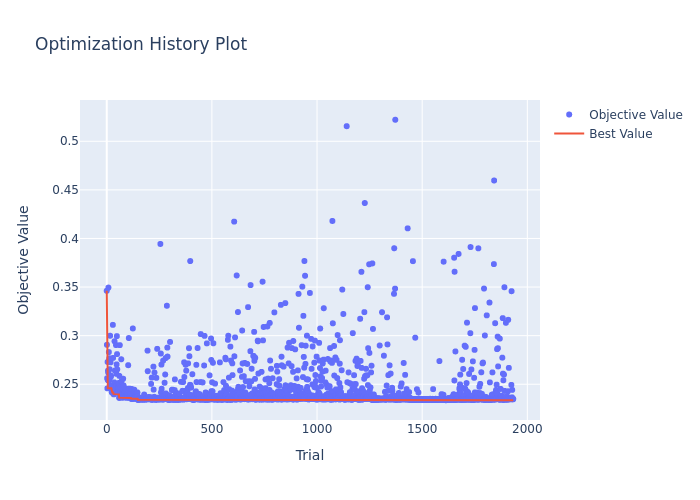

In [11]:
plot_optimization_history(study)

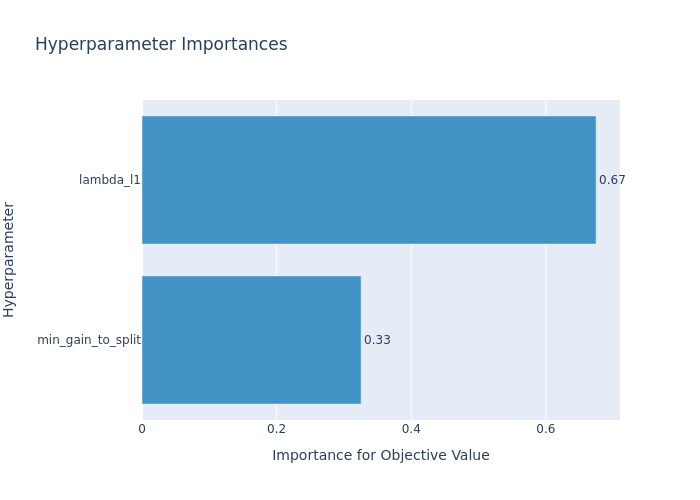

In [12]:
plot_param_importances(study)

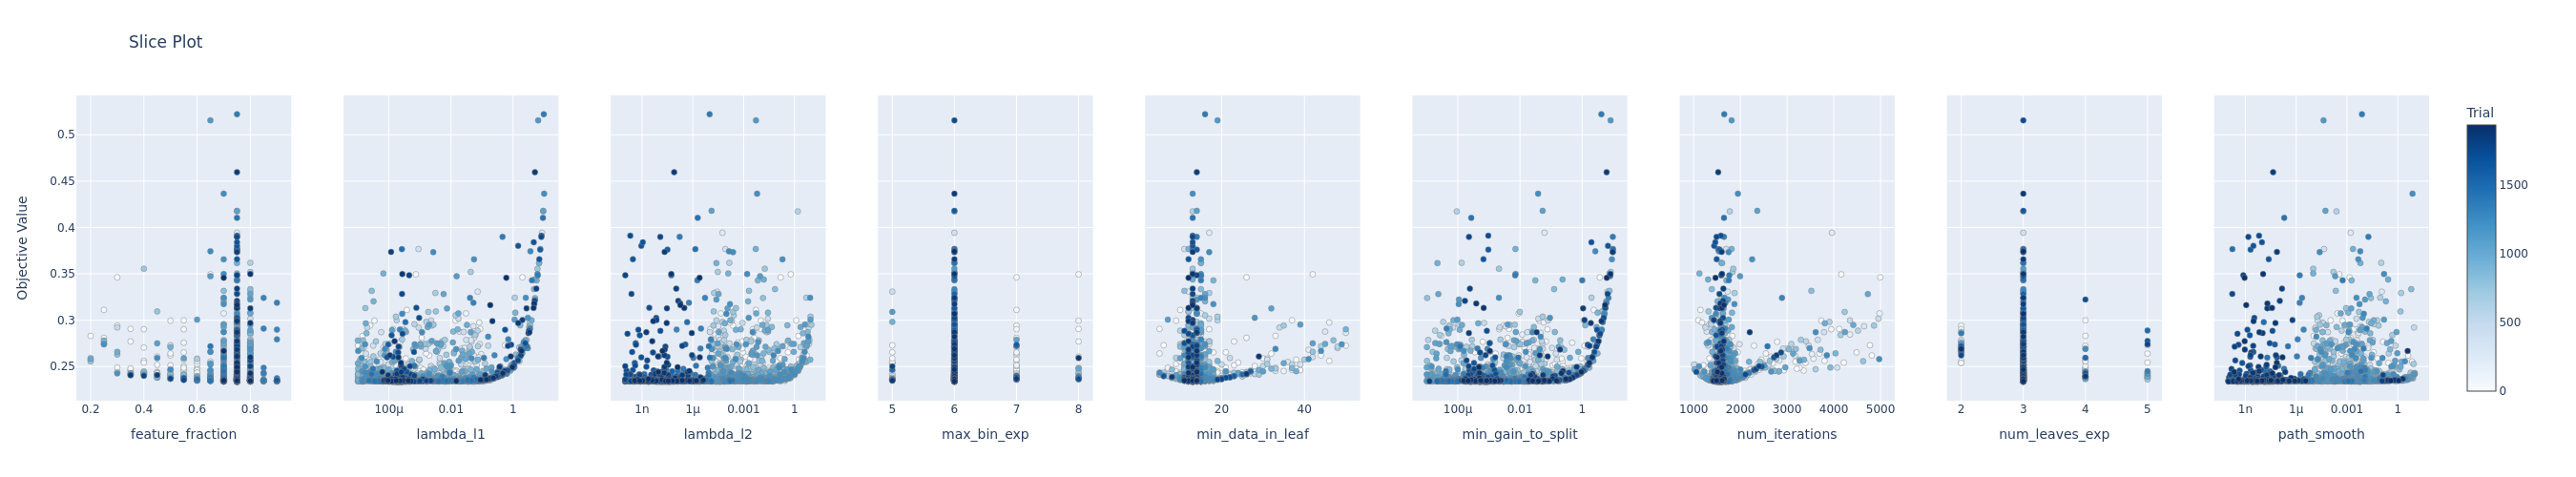

In [13]:
plot_slice(study)

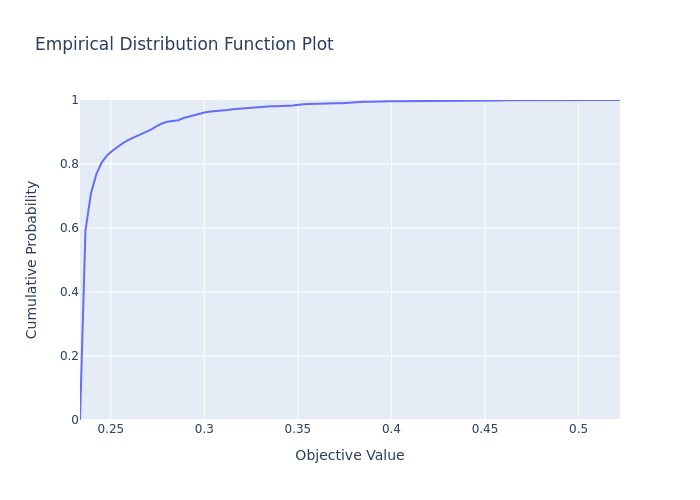

In [14]:
plot_edf(study)

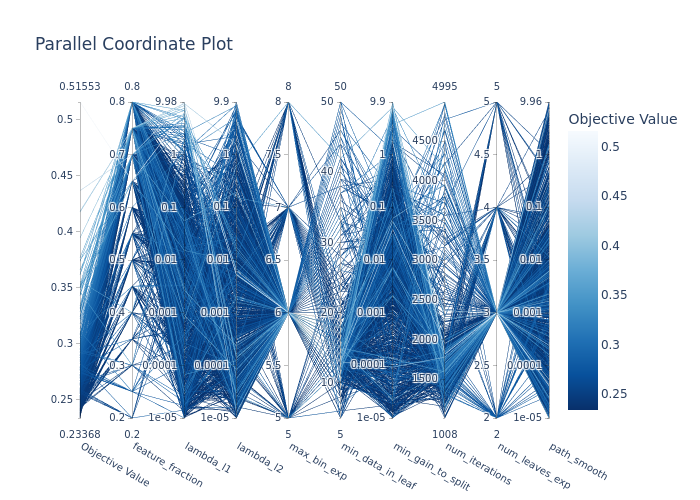

In [15]:
plot_parallel_coordinate(study)

In [16]:
best_params = dict(study.best_params)
#best_params["max_bin"] = 2**best_params.pop("max_bin_exp")-1
#best_params["num_leaves"] = 2**best_params.pop("num_leaves_exp")-1
best_params = {**DEFAULT_PARAMS, **best_params}
best_params

{'objective': 'binary',
 'metric': 'None',
 'learning_rate': 0.005,
 'max_bin': 63,
 'num_leaves': 7,
 'seed': 2112,
 'first_metric_only': False,
 'feature_pre_filter': False,
 'verbosity': -1,
 'bagging_freq': 1,
 'pos_bagging_fraction': 1,
 'neg_bagging_fraction': 0.21218074656188604,
 'feature_fraction': 0.75,
 'lambda_l1': 0.00020196676966216634,
 'lambda_l2': 2.3627262174517976e-09,
 'min_data_in_leaf': 13,
 'min_gain_to_split': 0.0007626326850799573,
 'num_iterations': 1591,
 'path_smooth': 2.652521741711401e-09}

***